In [1]:
#Import
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import os
import sys
sys.path.insert(0, '..')
from utils.clustering import *
from utils.federatedRL import *

import logging
logging.getLogger("wandb").setLevel(logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.ERROR)

os.environ['WANDB_SILENT'] = 'true'
os.environ['WANDB_CONSOLE'] = 'off'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
#Setup Environments of selected buildings for training, evaluation, and testing

environments, observation_spec, action_spec  = setup_energymanagement_environments(num_buildings=30, ecoPriority=1)
final_prosumption = setup_ausgrid_prosumption_data(file_path="../../data/Final_Energy_dataset.csv")

#Check environment setup
print(
    "Batch size:", environments["train"][f"building_1"].batch_size, 
    "/ State Space: {} / Action Space: {}".format(observation_spec.shape[0], action_spec.shape[0]),
    "/ Upper bound: {}".format(round(environments["train"][f"building_1"].action_spec().maximum.item(), 3)),
)

# Setup Agent networks
federated_rounds = 3
batch_size = 128
replay_buffer_capacity = 20000
initial_collect_steps = 2000
collect_steps_per_iteration = 30 
num_iterations = 10000 
eval_interval = num_iterations-1
best_federated_round = 0
num_rounds=3
num_test_iterations = 1

Batch size: 1 / State Space: 40 / Action Space: 1 / Upper bound: 2.3


<Figure size 1200x600 with 0 Axes>

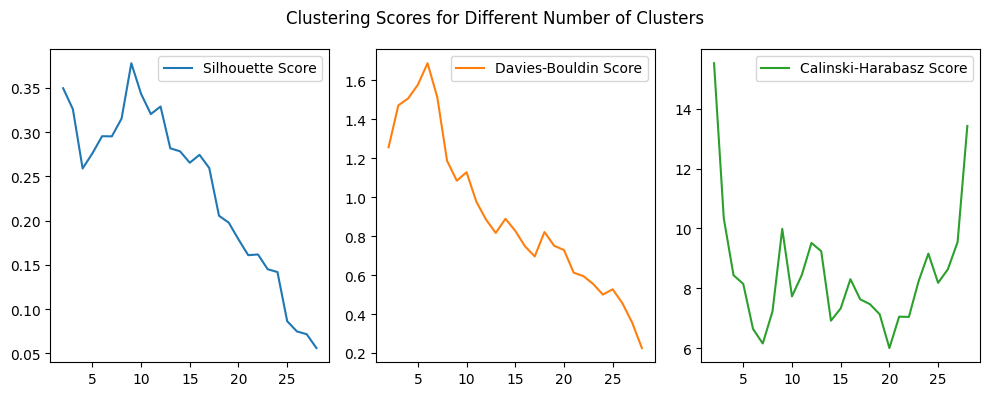

In [3]:
# Calculate Cluster Scores
kmeans_data = final_prosumption.copy()
kmeans_data = scaled_mean_over_48_timesteps(kmeans_data)

results = calculate_clustering_scores(kmeans_data, range(2,29), model_path_template="finalclustering/kmeans_mean_timeslot_{}.pkl")

plot_results(results)

In [4]:
for num_clusters in range(1,2):
    
    print("Cluster ", num_clusters)
    csv_name = f"KMeans_RL_Cluster_{num_clusters}"
    cluster = kmeans_clustered_buildings(num_clusters)
    cluster
    
    #Initalize global models
    initialize_fl_round_0(num_clusters, cluster, observation_spec, action_spec, environments)

    #Train models
    federated_learning_training(
        federated_rounds, num_clusters, cluster, observation_spec, action_spec, environments, replay_buffer_capacity,
        initial_collect_steps, collect_steps_per_iteration, batch_size, num_iterations
        )

    #Evaluate models
    results_df = local_refitting_and_evaluation(best_federated_round, num_rounds, num_test_iterations, cluster, observation_spec, action_spec,
        environments, replay_buffer_capacity, initial_collect_steps, collect_steps_per_iteration, batch_size, num_iterations, eval_interval, csv_name)

Cluster  1


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jonas-sievers (ipe). Use `wandb login --relogin` to force relogin


c:\Users\rs1044\Documents\GitHub\Effective-Clustering-in-Federated-Energy-Systems\src\notebooks\..\utils\federatedRL.py:429: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Building': [building_index], 'Total Profit': [wandb.summary["Final Profit"]], 'Total Emissions': [wandb.summary["Final Emissions"]]})], ignore_index=True)


"Action [2.3, -2.3]",▂▁▂▂▁▆▇▃▆▄▇▃▇█▄▇▅▇▄▇█▂▇▅▇▄▇█▄█▆▆▇▆▇▆▇▅▆▆
Battery wear cost,▆▃▁▁▁▄██████████████████████████████████
Emissions [kg],▂▃▁▅▂▆▁▁▂▁▅▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▅▂▅▁▂▁▁█▄
Final Emissions,▁
Final Profit,▁
Load,▃▄▁▅▂▆▁▁▃▂▅▂▂▂▃▂▂▁▃▂▁▁▁▂▁▂▁▂▁▁▁▅▂▅▂▃▁▁█▆
Net load,▄▅▄▆▄▇▃▃▅▃▆▄▄▂▃▄▄▄▃▄▁▃▃▄▄▄▃▂▃▂▄▆▄▆▄▄▃▄█▆
PV,▂▂▁▁▁▁▃▃▁▃▁▂▁▇▅▂▃▁▅▁█▂▂▂▁▂▁▆▁▇▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▆▄▇▃▆▃▇▇▅▇▄▆▇█▇▆▇▇▇▇█▇▇▆▇▇▇█▇█▇▃▆▃▇▆▇▇▁▃
Reward,▃▆███▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▁▂▁▂▂▃▂▆▃▇▃▇█▄▇▅▇▃▇█▂▇▅▇▄▇█▄█▆▇▇▆▇▆▇▅▆▆
Battery wear cost,▇▇▆▄▂▁▁▁▄███████████████████████████████
Emissions [kg],▂▃▁▅▂▆▁▁▃▁▅▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▅▂▅▁▂▁▁█▄
Final Emissions,▁
Final Profit,▁
Load,▃▄▁▅▂▆▁▁▃▂▅▂▂▂▃▂▂▁▃▂▁▁▁▂▁▂▁▂▁▁▁▅▂▅▂▃▁▁█▆
Net load,▄▅▄▆▄▇▃▃▅▃▆▄▄▂▃▄▄▄▃▄▁▃▃▄▄▄▃▂▃▂▄▆▄▆▄▄▃▄█▆
PV,▂▂▁▁▁▁▃▃▁▃▁▂▁▇▅▂▃▁▅▁█▂▂▂▁▂▁▆▁▇▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▆▄▇▃▆▃▇▇▅▇▄▆▇█▇▆▇▇▇▇█▇▇▆▇▇▇█▇█▇▃▆▃▇▆▇▇▁▃
Reward,▂▂▃▅▇███▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▁▂▁▁▃▆▃▆▃▆▃▇█▃▇▅▇▃▇█▂▇▅▇▄▇█▃█▆▆▇▆▇▆▇▅▆▆
Battery wear cost,▆▅▁▁▁▁▂█████████████████████████████████
Emissions [kg],▂▃▁▅▂▆▁▁▂▁▅▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▅▂▅▁▂▁▁█▄
Final Emissions,▁
Final Profit,▁
Load,▃▄▁▅▂▆▁▁▃▂▅▂▂▂▃▂▂▁▃▂▁▁▁▂▁▂▁▂▁▁▁▅▂▅▂▃▁▁█▆
Net load,▄▅▄▆▄▇▃▃▅▃▆▄▄▂▃▄▄▄▃▄▁▃▃▄▄▄▃▂▃▂▄▆▄▆▄▄▃▄█▆
PV,▂▂▁▁▁▁▃▃▁▃▁▂▁▇▅▂▃▁▅▁█▂▂▂▁▂▁▆▁▇▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▆▄▇▃▆▃▇▇▅▇▄▆▇█▇▆▇▇▇▇█▇▇▆▇▇▇█▇█▇▃▆▃▇▆▇▇▁▃
Reward,▃▄████▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▂▂▂▂▂▃▅█▆█████████▆▇▇█▆██▇▇▇███▇██▇█▆
Battery wear cost,█▇▆▅▃▁▁▁▁▁██████████████████████████████
Emissions [kg],▂▂▂▂▁▂▁▁▇▁▃▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▂▁▁▁▁▃▂▂█▁▃▁▃█
Final Emissions,▁
Final Profit,▁
Load,▂▂▂▂▂▂▂▂▇▁▂▁▁▁▁▁▁▁▁▁▂▂▂▂▁▂▂▂▂▃▁▃▂▂█▁▃▁▂█
Net load,▃▃▃▃▂▃▂▁█▁▃▁▂▂▂▂▂▂▂▂▂▃▃▃▃▂▃▂▂▂▃▃▃▃█▂▃▃▃█
PV,▁▂▁▁▆▁▂█▁█▁▆▁▁▁▁▁▁▁▁▅▂▂▄▁▂▁▅▅▆▁▁▁▁▂▂▂▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▇▇█▇▇█▂█▆██████████▇▇▇▇▇▇▇█▇▇▆▇▇▁▇▆▇▇▁
Reward,▂▂▃▄▆█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▁▁▂▂▄█▇█▇█▆█████████▆▇▇█▆██▇▇▇███▇██▇█▆
Battery wear cost,▆▅▁▁▁▁██████████████████████████████████
Emissions [kg],▂▂▂▂▁▂▁▁▇▁▃▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▂▁▁▁▁▃▂▂█▁▃▁▃█
Final Emissions,▁
Final Profit,▁
Load,▂▂▂▂▂▂▂▂▇▁▂▁▁▁▁▁▁▁▁▁▂▂▂▂▁▂▂▂▂▃▁▃▂▂█▁▃▁▂█
Net load,▃▃▃▃▂▃▂▁█▁▃▁▂▂▂▂▂▂▂▂▂▃▃▃▃▂▃▂▂▂▃▃▃▃█▂▃▃▃█
PV,▁▂▁▁▆▁▂█▁█▁▆▁▁▁▁▁▁▁▁▅▂▂▄▁▂▁▅▅▆▁▁▁▁▂▂▂▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▇▇█▇▇█▂█▆██████████▇▇▇▇▇▇▇█▇▇▆▇▇▁▇▆▇▇▁
Reward,▃▅████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▁▁▂▂▂▁▂▂▂▅▆█████████▆▇▇█▆██▇▇▇███▇██▇█▆
Battery wear cost,█▇█▇▆▅▂▁▁▁▁▆████████████████████████████
Emissions [kg],▂▂▂▂▁▂▁▁▇▁▃▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▂▁▁▁▁▃▂▂█▁▃▁▃█
Final Emissions,▁
Final Profit,▁
Load,▂▂▂▂▂▂▂▂▇▁▂▁▁▁▁▁▁▁▁▁▂▂▂▂▁▂▂▂▂▃▁▃▂▂█▁▃▁▂█
Net load,▃▃▃▃▂▃▂▁█▁▃▁▂▂▂▂▂▂▂▂▂▃▃▃▃▂▃▂▂▂▃▃▃▃█▂▃▃▃█
PV,▁▂▁▁▆▁▂█▁█▁▆▁▁▁▁▁▁▁▁▅▂▂▄▁▂▁▅▅▆▁▁▁▁▂▂▂▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▇▇█▇▇█▂█▆██████████▇▇▇▇▇▇▇█▇▇▆▇▇▁▇▆▇▇▁
Reward,▁▂▂▂▃▄▇████▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂▇█▇████████████████▇███▇██████████████
Battery wear cost,▁▁██████████████████████████████████████
Emissions [kg],▁▁█▁▁▁▁▂▂▁▂▁▂▁▁▂▁▁▁▂▁▁▂▁▂▁▂▁▁▄▁▂▁▂▁▁▁▁▂▁
Final Emissions,▁
Final Profit,▁
Load,▁▁█▁▁▁▁▃▁▁▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▅▁▂▁▁▁▁▁▁▁▁
Net load,▃▃█▃▂▃▃▄▃▁▃▁▃▂▁▃▂▃▁▃▁▃▃▂▃▂▃▂▂▅▃▃▃▃▃▃▃▃▃▃
PV,▁▁▂▁▄▁▂▄▁█▁▆▁▄▇▁▃▁▆▁▆▂▂▃▁▂▁▅▅▅▂▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▁▇█▇▇▆▇█▇█▇██▇▇▇█▇█▇▇█▇▇▇██▅▇▇▇▇▇▇▇▇▇▇
Reward,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂▇█▇████████████████▇███▇██████████████
Battery wear cost,▂▁██████████████████████████████████████
Emissions [kg],▁▁█▁▁▁▁▂▂▁▂▁▂▁▁▂▁▁▁▂▁▁▂▁▂▁▂▁▁▄▁▂▁▂▁▁▁▁▂▁
Final Emissions,▁
Final Profit,▁
Load,▁▁█▁▁▁▁▃▁▁▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▅▁▂▁▁▁▁▁▁▁▁
Net load,▃▃█▃▂▃▃▄▃▁▃▁▃▂▁▃▂▃▁▃▁▃▃▂▃▂▃▂▂▅▃▃▃▃▃▃▃▃▃▃
PV,▁▁▂▁▄▁▂▄▁█▁▆▁▄▇▁▃▁▆▁▆▂▂▃▁▂▁▅▅▅▂▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▁▇█▇▇▆▇█▇█▇██▇▇▇█▇█▇▇█▇▇▇██▅▇▇▇▇▇▇▇▇▇▇
Reward,▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▂▁▂▂▂▂▂▃▅█▇██▇█▇█▇██▇███▇██▇████████▇██
Battery wear cost,██▇▆▅▃▁▁▁▁██████████████████████████████
Emissions [kg],▁▁█▁▁▁▁▂▂▁▂▁▂▁▁▂▁▁▁▂▁▁▂▁▂▁▂▁▁▄▁▂▁▂▁▁▁▁▂▁
Final Emissions,▁
Final Profit,▁
Load,▁▁█▁▁▁▁▃▁▁▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▅▁▂▁▁▁▁▁▁▁▁
Net load,▃▃█▃▂▃▃▄▃▁▃▁▃▂▁▃▂▃▁▃▁▃▃▂▃▂▃▂▂▅▃▃▃▃▃▃▃▃▃▃
PV,▁▁▂▁▄▁▂▄▁█▁▆▁▄▇▁▃▁▆▁▆▂▂▃▁▂▁▅▅▅▂▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▁▇█▇▇▆▇█▇█▇██▇█▇█▇█▇▇█▇▇▇██▅▇▇▇▇▇▇▇▇▇▇
Reward,▁▂▂▃▄▆████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▁▁▁▁▂▁▂▂▁▂▄▆█▇█▇██▆█▇▇▇▇█▇█▇▇▇████▇█▇
Battery wear cost,█████▇▇▆▅▃▁▁▁▁▅█████████████████████████
Emissions [kg],▁▂▁▂▁▂▂▁▂▁▂▃▂▁▁▂▁▂▁▂▁▁▂▁▆▁▃▁▁▂▂▂▁▂▂█▂▁▂▃
Final Emissions,▁
Final Profit,▁
Load,▁▂▁▁▁▁▂▂▂▁▁▃▁▂▁▂▁▁▁▁▂▁▂▁▄▁▂▂▁▃▂▁▁▁▁█▂▁▁▃
Net load,▂▂▂▂▂▂▂▂▃▁▂▄▂▂▂▃▂▂▂▂▁▂▂▂▅▂▃▂▂▃▃▂▂▂▂█▂▂▂▄
PV,▁▁▂▁▂▁▂▄▁▄▁▂▁▆▂▁▂▁▁▁█▂▂▂▁▁▁▆▁▇▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇█▇█▇▇█▇█▇▆▇██▇█▇▇▇██▇█▅▇▇▇▇▇▇▇▇▇▇▁▇▇▇▆
Reward,▁▁▁▁▂▂▂▃▄▆████▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▁▁▁▁▂▁▁▂▂▅█▆█▇█▇██▆█▇▇▇██▇█▇█▇████▇█▇
Battery wear cost,████▇▇▆▄▃▁▁▁▁███████████████████████████
Emissions [kg],▁▂▁▂▁▂▂▁▂▁▂▃▂▁▁▂▁▂▁▂▁▁▂▁▆▁▃▁▁▂▂▂▁▂▂█▂▁▂▃
Final Emissions,▁
Final Profit,▁
Load,▁▂▁▁▁▁▂▂▂▁▁▃▁▂▁▂▁▁▁▁▂▁▂▁▄▁▂▂▁▃▂▁▁▁▁█▂▁▁▃
Net load,▂▂▂▂▂▂▂▂▃▁▂▄▂▂▂▃▂▂▂▂▁▂▂▂▅▂▃▂▂▃▃▂▂▂▂█▂▂▂▄
PV,▁▁▂▁▂▁▂▄▁▄▁▂▁▆▂▁▂▁▁▁█▂▂▂▁▁▁▆▁▇▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇█▇█▇▇█▇█▇▆▇██▇█▇▇▇██▇█▅▇▇▇▇▇▇▇▇▇▇▁▇▇▇▆
Reward,▁▁▂▂▂▂▃▅▆████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▁▂▁▁▁▂▂▅▆██▆█▇█▇██▆█▇▇▇▇█▇█▇█▇████▇█▇
Battery wear cost,██▇▆▆▄▂▁▁▁▁▁████████████████████████████
Emissions [kg],▁▂▁▂▁▂▂▁▂▁▂▃▂▁▁▂▁▂▁▂▁▁▂▁▆▁▃▁▁▂▂▂▁▂▂█▂▁▂▃
Final Emissions,▁
Final Profit,▁
Load,▁▂▁▁▁▁▂▂▂▁▁▃▁▂▁▂▁▁▁▁▂▁▂▁▄▁▂▂▁▃▂▁▁▁▁█▂▁▁▃
Net load,▂▂▂▂▂▂▂▂▃▁▂▄▂▂▂▃▂▂▂▂▁▂▂▂▅▂▃▂▂▃▃▂▂▂▂█▂▂▂▄
PV,▁▁▂▁▂▁▂▄▁▄▁▂▁▆▂▁▂▁▁▁█▂▂▂▁▁▁▆▁▇▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇█▇█▇▇█▇█▇▆▇██▇█▇▇▇██▇█▅▇▇▇▇▇▇▇▇▇▇▁▇▇▇▆
Reward,▁▂▂▃▃▅▇█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▂▂▁▂▁▂▂▃▅█▇██▇█▇█▇██▇███▇██▇█▇▇█▇█▇█▇▇▇
Battery wear cost,█▇▇▆▅▃▁▁▁▁██████████████████████████████
Emissions [kg],▁▂▁█▁█▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▂▁▂▂▂█▂▂▁▂█▄
Final Emissions,▁
Final Profit,▁
Load,▁▂▂█▁█▁▁▁▁▁▁▁▂▁▂▁▂▂▂▂▂▂▁▁▁▁▁▂▂▂▂▂█▃▃▁▂█▅
Net load,▂▂▂█▁█▂▁▂▁▂▁▂▂▁▂▂▂▂▂▁▂▂▁▂▁▂▁▃▂▃▃▂█▃▃▂▃█▅
PV,▂▁▂▁▅▁▂▇▁█▁▅▁▆▆▂▅▁▆▁█▂▄▃▁▂▁▆▃▇▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▇▁█▁██▇███▇██▇█▇█▇█▇▇█████▇▇▇▇▇▁▆▆▇▇▁▄
Reward,▂▂▂▃▄▆████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂█▇█▇███████████████▇██████▇██▇█▇████▇█
Battery wear cost,▁▁██████████████████████████████████████
Emissions [kg],▁▂▁█▁█▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▂▁▂▂▂█▂▂▁▂█▄
Final Emissions,▁
Final Profit,▁
Load,▁▂▂█▁█▁▁▁▁▁▁▁▂▁▂▁▂▂▂▂▂▂▁▁▁▁▁▂▂▂▂▂█▃▃▁▂█▅
Net load,▂▂▂█▁█▂▁▂▁▂▁▂▂▁▂▂▂▂▂▁▂▂▁▂▁▂▁▃▂▃▃▂█▃▃▂▃█▅
PV,▂▁▂▁▅▁▂▇▁█▁▅▁▆▆▂▅▁▆▁█▂▄▃▁▂▁▆▃▇▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▇▁█▁██▇███▇██▇█▇█▇█▇▇█████▇▇▇▇▇▁▆▆▇▇▁▄
Reward,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▃▇█▇█████▇██▇███▇██▇███▇██▇█▇▇█▇███▇▇▇
Battery wear cost,▅▁▁█████████████████████████████████████
Emissions [kg],▁▂▂█▁█▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▂▁▂▂▂█▂▂▁▂█▄
Final Emissions,▁
Final Profit,▁
Load,▁▂▂█▁█▁▁▁▁▁▁▁▂▁▂▁▂▂▂▂▂▂▁▁▁▁▁▂▂▂▂▂█▃▃▁▂█▅
Net load,▂▂▂█▁█▂▁▂▁▂▁▂▂▁▂▂▂▂▂▁▂▂▁▂▁▂▁▃▂▃▃▂█▃▃▂▃█▅
PV,▂▁▂▁▅▁▂▇▁█▁▅▁▆▆▂▅▁▆▁█▂▄▃▁▂▁▆▃▇▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▇▁█▁██▇███▇██▇█▇█▇█▇▇█████▇▇▇▇▇▁▆▆▇▇▁▄
Reward,▄██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▂▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▂▂▃▃▂▃▃▆███▇██
Battery wear cost,███████████████████████████▆▄▁▁▁▁▁██████
Emissions [kg],▄▂▂█▂█▂▁▁▂▇▁▁▁▂▁▁▁▂▁▂▁▁▁▁▂▁▂▂▁▂▇▂▇▁▁▁▃▇▁
Final Emissions,▁
Final Profit,▁
Load,▅▂▂█▃█▂▁▁▂▇▁▁▁▂▁▂▁▃▁▃▂▁▁▁▂▁▃▃▁▃▇▃▇▁▂▂▃▇▁
Net load,▅▂▂█▂█▂▁▁▂▇▁▁▁▂▁▂▁▃▁▃▂▁▁▁▂▁▂▂▁▃▇▃▇▁▁▂▃▇▁
PV,▃▁▂▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▄▄▁▁▁▁▁▃▂▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▄▇▇▁▆▂▇██▇▂███▇█▇█▆█▆████▇█▇▇█▇▂▆▂█▇█▆▂█
Reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▆█████▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂▇█▇█████████▇██████████▇██▇█▇██████▇██
Battery wear cost,▁▁██████████████████████████████████████
Emissions [kg],▄▂▂█▂█▂▁▁▂▇▁▁▁▂▁▁▁▂▁▂▁▁▁▁▂▁▂▂▁▂▇▂▇▁▁▁▃▇▁
Final Emissions,▁
Final Profit,▁
Load,▅▂▂█▃█▂▁▁▂▇▁▁▁▂▁▂▁▃▁▃▂▁▁▁▂▁▃▃▁▃▇▃▇▁▂▂▃▇▁
Net load,▅▂▂█▂█▂▁▁▂▇▁▁▁▂▁▂▁▃▁▃▂▁▁▁▂▁▂▂▁▃▇▃▇▁▁▂▃▇▁
PV,▃▁▂▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▄▄▁▁▁▁▁▃▂▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▄▇▇▁▆▂▇██▇▂███▇█▇█▆█▆████▇█▇▇█▇▂▆▂█▇█▆▂█
Reward,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂▇█▇█████████▇██████████▇██▇█▇██████▇██
Battery wear cost,▁▁██████████████████████████████████████
Emissions [kg],▄▂▂█▂█▂▁▁▂▇▁▁▁▂▁▁▁▂▁▂▁▁▁▁▂▁▂▂▁▂▇▂▇▁▁▁▃▇▁
Final Emissions,▁
Final Profit,▁
Load,▅▂▂█▃█▂▁▁▂▇▁▁▁▂▁▂▁▃▁▃▂▁▁▁▂▁▃▃▁▃▇▃▇▁▂▂▃▇▁
Net load,▅▂▂█▂█▂▁▁▂▇▁▁▁▂▁▂▁▃▁▃▂▁▁▁▂▁▂▂▁▃▇▃▇▁▁▂▃▇▁
PV,▃▁▂▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▄▄▁▁▁▁▁▃▂▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▄▇▇▁▆▂▇██▇▂███▇█▇█▆█▆████▇█▇▇█▇▂▆▂█▇█▆▂█
Reward,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▂▂▅█▆█▆▇▅██▆▇▆▇▆▇█▅█▇▇▇▇█▅█▇▇▇▇█▇▇▇▇█
Battery wear cost,▆▃▁▁▁▁██████████████████████████████████
Emissions [kg],▂▁▁█▁▇▁▁▁▁█▁▂▁▁▁▁▃▁▆▁▁▂▁▆▁▆▁▂▁▂█▁▂▁▂▁▁█▁
Final Emissions,▁
Final Profit,▁
Load,▂▁▁█▁█▁▁▁▁█▁▁▁▁▁▁▂▁▆▁▁▃▁▆▂▆▂▂▂▂█▁▂▁▂▂▁█▁
Net load,▃▃▂█▂█▂▁▃▁█▂▃▁▁▃▂▄▂▆▁▃▃▂▇▃▆▂▃▂▃█▃▃▃▃▃▃█▃
PV,▁▂▂▁▆▁▂▇▁█▁▃▁▆▇▂▄▁▆▁█▁▃▃▁▂▁▇▁▇▂▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▇▁█▁██▇█▁█▇██▇█▆█▃█▇▆█▃▇▃█▇█▇▁▇▆▇▆▇▇▁▇
Reward,▃▆████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▃██▇██▇█▇▇▇██▇█▇▇▇██▇██▇█▇█▇█▇▇█▇███▇▇█
Battery wear cost,▁▁██████████████████████████████████████
Emissions [kg],▂▁▁█▁▇▁▁▁▁█▁▂▁▁▁▁▃▁▆▁▁▂▁▆▁▆▁▂▁▂█▁▂▁▂▁▁█▁
Final Emissions,▁
Final Profit,▁
Load,▂▁▁█▁█▁▁▁▁█▁▁▁▁▁▁▂▁▆▁▁▃▁▆▂▆▂▂▂▂█▁▂▁▂▂▁█▁
Net load,▃▃▂█▂█▂▁▃▁█▂▃▁▁▃▂▄▂▆▁▃▃▂▇▃▆▂▃▂▃█▃▃▃▃▃▃█▃
PV,▁▂▂▁▆▁▂▇▁█▁▃▁▆▇▂▄▁▆▁█▁▃▃▁▂▁▇▁▇▂▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▆▇▇▁█▁██▇█▁█▇██▇█▆█▃█▇▆█▃▇▃█▇█▇▁▇▆▇▆▇▇▁▇
Reward,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▂▂▃▆▆▇▆▇▅██▆▇▆▇▅▇█▅█▇▇▇▆█▅█▇▇▇▇█▇▇▆▇▇
Battery wear cost,▇▅▂▁▁▁▁█████████████████████████████████
Emissions [kg],▂▁▁█▁▇▁▁▁▁█▁▂▁▁▁▁▃▁▆▁▁▂▁▆▁▆▁▂▁▂█▁▂▁▂▁▁█▁
Final Emissions,▁
Final Profit,▁
Load,▂▁▁█▁█▁▁▁▁█▁▁▁▁▁▁▂▁▆▁▁▃▁▆▂▆▂▂▂▂█▁▂▁▂▂▁█▁
Net load,▃▃▂█▂█▂▁▃▁█▂▃▁▁▃▂▄▂▆▁▃▃▂▇▃▆▂▃▂▃█▃▃▃▃▃▃█▃
PV,▁▂▂▁▆▁▂▇▁█▁▃▁▆▇▂▄▁▆▁█▁▃▃▁▂▁▇▁▇▂▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▇▁█▁▇█▇█▁█▇██▇█▆█▃█▇▆█▃▇▃█▇█▇▁▇▆▇▆▇▇▁▇
Reward,▂▄▇████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▆▄▆▂▄▃▅▆▆▇▇▇▄▆█▆▇▂▇▃▆█▅▆▂▇▂▆▆▄▅▂▆▁▆▁▅▃▂▄
Battery wear cost,█████████▇▇██▇▇███▇█▄▅▁█████▇███████████
Emissions [kg],▁▂▂█▂▁▂▁▂▁▁▁▂▄▁▂▁▇▁▂▁▁▂▄▂▂▂▂▃▃▄▅▁▄▂▄▃▂█▅
Final Emissions,▁
Final Profit,▁
Load,▁▃▂█▃▁▃▂▂▂▁▂▁▅▁▂▁█▂▁▁▁▃▄▁▃▂▂▄▃▅▅▁▄▂▄▄▂█▇
Net load,▂▃▂█▃▂▃▂▂▁▂▂▂▅▁▂▂█▁▂▁▁▃▅▂▃▃▃▄▄▅▅▂▄▂▅▅▃█▇
PV,▂▁▂▁▅▁▂▇▁█▁▇▁▂█▂▂▁█▁▄▄▂▂▁▆▁▃▆▁▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",█▆▇▁▆█▆▇▇███▇▄█▇█▂█▇██▆▅▇▆▇▇▅▅▄▄▇▅▇▄▅▇▁▂
Reward,▂▂▂▁▂▂▂▂▂▂▃▂▂▂▃▂▂▁▃▂▆▅█▂▂▂▂▂▃▂▂▁▂▁▂▂▂▂▁▁


"Action [2.3, -2.3]",▁▂█████████████████▇████▇██████▇█▇█▇████
Battery wear cost,▂▁██████████████████████████████████████
Emissions [kg],▁▂▂█▂▁▂▁▂▁▁▁▂▄▁▂▁▇▁▂▁▁▂▄▂▂▂▂▃▃▄▅▁▄▂▄▃▂█▅
Final Emissions,▁
Final Profit,▁
Load,▁▃▂█▃▁▃▂▂▂▁▂▁▅▁▂▁█▂▁▁▁▃▄▁▃▂▂▄▃▅▅▁▄▂▄▄▂█▇
Net load,▂▃▂█▃▂▃▂▂▁▂▂▂▅▁▂▂█▁▂▁▁▃▅▂▃▃▃▄▄▅▅▂▄▂▅▅▃█▇
PV,▂▁▂▁▅▁▂▇▁█▁▇▁▂█▂▂▁█▁▄▄▂▂▁▆▁▃▆▁▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",█▆▇▁▆█▆▇▇███▇▄█▇█▂█▇██▆▅▇▆▇▇▅▅▄▄▇▅▇▄▅▇▁▂
Reward,▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▁▂▁▂▁▂▂▂▃▃▃▂▂▃▂▂▁▃▁▂▃▂▂▂▂▃▃▅▆█▇█▇█▆█▇▇▇
Battery wear cost,██████████▇▇▇▇▆▆▆▇▇▇▅▄▂▂▁▁▁▁▁▁██████████
Emissions [kg],▁▂▂█▂▁▂▁▂▁▁▁▂▄▁▂▁▇▁▂▁▁▂▄▂▂▂▂▃▃▄▅▁▄▂▄▃▂█▅
Final Emissions,▁
Final Profit,▁
Load,▁▃▂█▃▁▃▂▂▂▁▂▁▅▁▂▁█▂▁▁▁▃▄▁▃▂▂▄▃▅▅▁▄▂▄▄▂█▇
Net load,▂▃▂█▃▂▃▂▂▁▂▂▂▅▁▂▂█▁▂▁▁▃▅▂▃▃▃▄▄▅▅▂▄▂▅▅▃█▇
PV,▂▁▂▁▅▁▂▇▁█▁▇▁▂█▂▂▁█▁▄▄▂▂▁▆▁▃▆▁▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",█▆▇▁▆█▆▇▇███▇▄█▇█▂█▇██▆▅▇▆▇▆▅▅▄▄▇▅▇▄▅▇▁▂
Reward,▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▂▃▃▄▅▇▇██████▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▂▁▁▂▂▂▃▂▂▃▄▇█▇█▇▇▇▇█▇███▇██▇██▇█▇███▇▇█
Battery wear cost,█▇▇▇▇▇▆▃▁▁▁▁████████████████████████████
Emissions [kg],▁▁▄█▁▃▁▁▁▃▁▁▁▁▁▁▁▄▁▅▁▁▁▁▁▁▁▁▁▁▁▄▁▄▁▁▁▂▃▂
Final Emissions,▁
Final Profit,▁
Load,▁▁▆█▁▃▁▁▁▄▁▁▁▁▁▁▁▄▁▆▁▁▁▁▁▁▁▁▁▁▁▄▂▄▁▂▁▂▃▂
Net load,▂▂▆█▁▃▂▁▂▄▂▁▂▂▁▂▂▄▁▆▁▂▂▂▂▂▂▁▁▁▂▅▂▅▂▂▂▂▄▂
PV,▂▂▂▁▆▁▃█▁█▁▅▁▆▆▂▃▁▆▁█▂▁▃▁▂▁▇▄▇▂▁▁▁▁▂▂▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",██▄▁█▆██▇▆▇██████▅█▄█▇█████████▅▇▅▇▇▇▇▆▇
Reward,▂▂▂▂▂▂▄▆████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▂▂▁▃▂▂▃▂▂▂▃▂▃▃▄▆▇▇▇█▇███▇██▇██▇█▇███▇▇█
Battery wear cost,████████▇▇▅▄▁▁▁▁▁███████████████████████
Emissions [kg],▁▁▄█▁▃▁▁▁▃▁▁▁▁▁▁▁▄▁▆▁▁▁▁▁▁▁▁▁▁▁▄▁▄▁▁▁▂▃▂
Final Emissions,▁
Final Profit,▁
Load,▁▁▆█▁▃▁▁▁▄▁▁▁▁▁▁▁▄▁▆▁▁▁▁▁▁▁▁▁▁▁▄▂▄▁▂▁▂▃▂
Net load,▂▂▆█▁▃▂▁▂▄▂▁▂▂▁▂▂▄▁▆▁▂▂▂▂▂▂▁▁▁▂▅▂▅▂▂▂▂▄▂
PV,▂▂▂▁▆▁▃█▁█▁▅▁▆▆▂▃▁▆▁█▂▁▃▁▂▁▇▄▇▂▁▁▁▁▂▂▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",██▄▁█▆██▇▆▇██████▅█▄█▇█████████▅▇▅▇▇▇▇▆▇
Reward,▁▁▁▁▁▁▁▂▂▂▄▅█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂▇▇█████▇███████▇█▇█▇██████▇██▇█▇████▇█
Battery wear cost,▁▁██████████████████████████████████████
Emissions [kg],▁▁▄█▁▃▁▁▁▃▁▁▁▁▁▁▁▄▁▅▁▁▁▁▁▁▁▁▁▁▁▄▁▄▁▁▁▂▃▂
Final Emissions,▁
Final Profit,▁
Load,▁▁▆█▁▃▁▁▁▄▁▁▁▁▁▁▁▄▁▆▁▁▁▁▁▁▁▁▁▁▁▄▂▄▁▂▁▂▃▂
Net load,▂▂▆█▁▃▂▁▂▄▂▁▂▂▁▂▂▄▁▆▁▂▂▂▂▂▂▁▁▁▂▅▂▅▂▂▂▂▄▂
PV,▂▂▂▁▆▁▃█▁█▁▅▁▆▆▂▃▁▆▁█▂▁▃▁▂▁▇▄▇▂▁▁▁▁▂▂▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",██▄▁█▆██▇▆▇██████▅█▄█▇█████████▅▇▅▇▇▇▇▆▇
Reward,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▃▃▂▃▃▁▃▃▃▃▃▃▃▅▆█▇▆▇▆█▇█▇▇▇▇█▇██▇██▇█▇▇▇█
Battery wear cost,██████▇▆▅▃▁▁▁▁▅█████████████████████████
Emissions [kg],▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▃█▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▃▁▁▃
Final Emissions,▁
Final Profit,▁
Load,▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▄█▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▃▁▃▁▁▃
Net load,▂▁▄▁▂▂▁▂▂▂▁▂▂▁▁▂▄█▂▃▁▂▂▁▂▁▁▁▁▁▂▁▂▁▃▂▃▂▂▃
PV,▁▁▁▁▁▁▂▁▁▁▁▁▁▆▁▁▂▁▁▁█▁▁▂▁▂▁▇▁▇▁▁▁▁▁▁▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇█▆█████▇███████▅▁█▆█▇▇███████████▆█▆██▆
Reward,▁▁▁▂▂▂▂▃▄▆████▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂███▇█▇█▇█▇██▇█▇▇▇▇█▇██████▇███████████
Battery wear cost,▁▁██████████████████████████████████████
Emissions [kg],▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▃█▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▃▁▁▃
Final Emissions,▁
Final Profit,▁
Load,▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▄█▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▃▁▃▁▁▃
Net load,▂▁▄▁▂▂▁▂▂▂▁▂▂▁▁▂▄█▂▃▁▂▂▁▂▁▁▁▁▁▂▁▂▁▃▂▃▂▂▃
PV,▁▁▁▁▁▁▂▁▁▁▁▁▁▆▁▁▂▁▁▁█▁▁▂▁▂▁▇▁▇▁▁▁▁▁▁▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇█▆█████▇███████▅▁█▆█▇▇███████████▆█▆██▆
Reward,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▂▂▃▃▁▂▃▂▃▃▃▃▄▅█▇▆▇▆█▇█▇▇▇▇█▇██▇██▇█▇▇▇█
Battery wear cost,██████▇▆▅▃▁▁▁▁▁█████████████████████████
Emissions [kg],▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▃█▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▃▁▁▃
Final Emissions,▁
Final Profit,▁
Load,▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▄█▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▃▁▃▁▁▃
Net load,▂▁▄▁▂▂▁▂▂▂▁▂▂▁▁▂▄█▂▃▁▂▂▁▂▁▁▁▁▁▂▁▂▁▃▂▃▂▂▃
PV,▁▁▁▁▁▁▂▁▁▁▁▁▁▆▁▁▂▁▁▁█▁▁▂▁▂▁▇▁▇▁▁▁▁▁▁▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇█▆█████▇███████▅▁█▆█▇▇███████████▆█▆██▆
Reward,▁▁▁▂▂▂▂▃▄▆█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▂▁▂▁▁▂▁▂▃▂▆█▅▇▇▇▅▇█▅▇▆▇▆▇█▅█▇▇▇▇▇▇█▇█▇
Battery wear cost,████▇█▆▃▁▁▁▁▁███████████████████████████
Emissions [kg],▃▃▄▂▁▆▃▁▂▁▃▂▃▅▅▄▂█▂▂▁▅▄▃▃▂█▁▂▁▆▃▂▂▆▅▂▂▂▃
Final Emissions,▁
Final Profit,▁
Load,▃▃▄▁▂▄▄▁▂▂▂▃▂█▅▃▂▆▁▁▃▅▄▂▁▂▆▂▁▂▅▁▁▁▇▅▂▁▁▂
Net load,▅▅▆▄▂▆▅▁▄▁▄▄▄▆▆▅▃█▄▃▂▇▅▄▄▄█▂▃▂▇▄▄▄█▆▄▄▄▄
PV,▂▁▂▁▅▁▃▇▁▇▁▄▁▇▂▁▃▁▂▁█▁▂▂▁▂▁▆▂▆▁▁▁▁▁▂▂▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▅▅▄▆█▃▅█▆█▆▆▆▃▃▄▇▁▆▆█▃▄▅▆▆▂█▇█▂▆▆▆▁▃▆▆▆▅
Reward,▁▁▁▁▂▁▃▆█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▂▁▂▁▂▂▃▄█▅▇█▅▇▇▇▅▇█▅▇▆▇▆▇█▅█▇▇▇▇▇▇▇▆█▇
Battery wear cost,▇▇▇▆▄▃▁▁▁▁██████████████████████████████
Emissions [kg],▃▃▄▂▁▆▃▁▂▁▃▂▃▅▅▄▂█▂▂▁▅▄▃▃▂█▁▂▁▆▃▂▂▆▅▂▂▂▃
Final Emissions,▁
Final Profit,▁
Load,▃▃▄▁▂▄▄▁▂▂▂▃▂█▅▃▂▆▁▁▃▅▄▂▁▂▆▂▁▂▅▁▁▁▇▅▂▁▁▂
Net load,▅▅▆▄▂▆▅▁▄▁▄▄▄▆▆▅▃█▄▃▂▇▅▄▄▄█▂▃▂▇▄▄▄█▆▄▄▄▄
PV,▂▁▂▁▅▁▃▇▁▇▁▄▁▇▂▁▃▁▂▁█▁▂▂▁▂▁▆▂▆▁▁▁▁▁▂▂▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▅▅▄▆█▃▅█▆█▆▆▆▃▃▄▇▁▆▆█▃▄▅▆▆▂█▇█▂▆▆▆▁▃▆▆▆▅
Reward,▂▂▂▃▅▆████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▂▁▂▂▃▃▆▆█▅▇█▅▇▇▇▅▇█▅▇▆▇▆▇█▅█▇▇▇▇▇▇▇▆█▇
Battery wear cost,▇▆▅▂▁▁▁▁▁███████████████████████████████
Emissions [kg],▃▃▄▂▁▆▃▁▂▁▃▂▃▅▅▄▂█▂▂▁▅▄▃▃▂█▁▂▁▆▃▂▂▆▅▂▂▂▃
Final Emissions,▁
Final Profit,▁
Load,▃▃▄▁▂▄▄▁▂▂▂▃▂█▅▃▂▆▁▁▃▅▄▂▁▂▆▂▁▂▅▁▁▁▇▅▂▁▁▂
Net load,▅▅▆▄▂▆▅▁▄▁▄▄▄▆▆▅▃█▄▃▂▇▅▄▄▄█▂▃▂▇▄▄▄█▆▄▄▄▄
PV,▂▁▂▁▅▁▃▇▁▇▁▄▁▇▂▁▃▁▂▁█▁▂▂▁▂▁▆▂▆▁▁▁▁▁▂▂▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▅▅▄▆█▃▅█▆█▆▆▆▃▃▄▇▁▆▆█▃▄▅▆▆▂█▇█▂▆▆▆▁▃▆▆▆▅
Reward,▂▃▄▇█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▁▁▁▂▁▁▂▁▂▂▂▃▅▇█▇█▇██▇█▇█▇██▇█▇▇▇████▇█▇
Battery wear cost,█████▇▆▅▄▁▁▁▁▁██████████████████████████
Emissions [kg],▂▂▃▂▁▂▂▁▃▁▂▁▂▂▁▃▂▂▂▂▂▃▃▃▂▂▂▃▂▂▁▃▃▂▃▁▃▂▂█
Final Emissions,▁
Final Profit,▁
Load,▂▂▃▁▁▂▂▁▃▂▂▁▂▃▁▂▂▂▂▂▃▃▃▃▁▂▂▃▁▃▁▂▃▂▃▁▃▂▂█
Net load,▂▃▃▂▁▂▂▁▃▁▂▁▂▂▁▃▂▂▂▂▂▃▃▃▂▂▂▃▂▂▁▂▃▂▃▁▃▂▂█
PV,▁▂▂▁▂▁▃▃▁▄▁▂▁▇▃▂▂▁▃▁█▂▂▂▁▁▁▅▁▇▁▁▁▁▁▂▂▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▆▇█▇▇█▆█▇█▇▇█▆▇▇▇▇▇▆▆▆▇▇▇▆▇▇█▇▆▇▆█▆▇▇▁
Reward,▁▁▁▁▂▂▃▄▅█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▁▁▁▁▂▄▆█▇█▇██▇█▇█▇██▇█▇▇▇██▇█▇▇▇▇███▇█▇
Battery wear cost,▇▆▃▁▁▁▁▂████████████████████████████████
Emissions [kg],▂▂▃▂▁▂▂▁▃▁▂▁▂▂▁▃▂▂▂▂▂▃▃▃▂▂▂▃▂▂▁▃▃▂▃▁▃▂▂█
Final Emissions,▁
Final Profit,▁
Load,▂▂▃▁▁▂▂▁▃▂▂▁▂▃▁▂▂▂▂▂▃▃▃▃▁▂▂▃▁▃▁▂▃▂▃▁▃▂▂█
Net load,▂▃▃▂▁▂▂▁▃▁▂▁▂▂▁▃▂▂▂▂▂▃▃▃▂▂▂▃▂▂▁▂▃▂▃▁▃▂▂█
PV,▁▂▂▁▂▁▃▃▁▄▁▂▁▇▃▂▂▁▃▁█▂▂▂▁▁▁▅▁▇▁▁▁▁▁▂▂▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▆▇█▇▇█▆█▇█▇▇█▆▇▇▇▇▇▆▆▆▇▇▇▆▇▇█▇▆▇▆█▆▇▇▁
Reward,▂▃▆████▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▁▁▁▂▁▁▁▂▂▆▇██▇█▇█▇██▇█▇▇▇██▇█▇▇▇▇███▇█▇
Battery wear cost,▇▇▆▅▄▃▁▁▁▁▁█████████████████████████████
Emissions [kg],▂▂▃▂▁▂▂▁▃▁▂▁▂▂▁▃▂▂▂▂▂▃▃▃▂▂▂▃▂▂▁▃▃▂▃▁▃▂▂█
Final Emissions,▁
Final Profit,▁
Load,▂▂▃▁▁▂▂▁▃▂▂▁▂▃▁▂▂▂▂▂▃▃▃▃▁▂▂▃▁▃▁▂▃▂▃▁▃▂▂█
Net load,▂▃▃▂▁▂▂▁▃▁▂▁▂▂▁▃▂▂▂▂▂▃▃▃▂▂▂▃▂▂▁▂▃▂▃▁▃▂▂█
PV,▁▂▂▁▂▁▃▃▁▄▁▂▁▇▃▂▂▁▃▁█▂▂▂▁▁▁▅▁▇▁▁▁▁▁▂▂▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▆▇█▇▇█▆█▇█▇▇█▆▇▇▇▇▇▆▆▆▇▇▇▆▇▇█▇▆▇▆█▆▇▇▁
Reward,▂▂▃▄▅▆█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▃▇▇▇██▇▇▇█▇██▇█▇█▇██▇█▇█▇██▇█▇█████▇▇█▇
Battery wear cost,▁▁██████████████████████████████████████
Emissions [kg],▁▂▁█▁▂▁▁▂▁▁▄▂▅▁▂▁▁▁▂▁▁▁▁▁▁▁▁▃▁▃▁▁▁▂▁▂▂▁▇
Final Emissions,▁
Final Profit,▁
Load,▁▂▁▆▁▂▂▂▂▂▁▄▁█▁▂▁▁▁▂▂▁▂▁▁▁▁▁▃▂▃▁▁▁▂▁▂▂▁▇
Net load,▃▄▄▇▄▄▄▄▄▃▄▆▄▆▃▄▃▄▃▄▂▄▄▃▄▄▄▁▅▂▅▄▄▄▅▄▄▄▄█
PV,▁▁▁▁▂▁▂▃▁▃▁▂▁▇▂▁▃▁▂▁█▂▃▂▁▁▁█▁▇▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▆▇▂▇▆▇▇▆▇▇▄▇▃▇▆▇▇▇▆█▇▆▇▇▇▇█▅█▅▇▇▇▆▇▆▆▇▁
Reward,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▂▂▁▂▂▂▂▃▃▇▅▇█▅▇▆▇▅▇█▅▇▇▇▆▇█▅█▆▇▇▇▇▇▇▆▇▇
Battery wear cost,██▇▇▆▄▁▁▁▁██████████████████████████████
Emissions [kg],▁▂▁█▁▂▁▁▂▁▁▄▂▅▁▂▁▁▁▂▁▁▁▁▁▁▁▁▃▁▃▁▁▁▂▁▂▂▁▇
Final Emissions,▁
Final Profit,▁
Load,▁▂▁▆▁▂▂▂▂▂▁▄▁█▁▂▁▁▁▂▂▁▂▁▁▁▁▁▃▂▃▁▁▁▂▁▂▂▁▇
Net load,▃▄▄▇▄▄▄▄▄▃▄▆▄▆▃▄▃▄▃▄▂▄▄▃▄▄▄▁▅▂▅▄▄▄▅▄▄▄▄█
PV,▁▁▁▁▂▁▂▃▁▃▁▂▁▇▂▁▃▁▂▁█▂▃▂▁▁▁█▁▇▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▆▇▂▇▆▇▇▆▇▇▄▇▃▇▆▇▇▇▆█▇▆▇▇▇▇█▅█▅▇▇▇▆▇▆▆▇▁
Reward,▁▁▂▂▃▅████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▂▂▁▂▂▂▂▃▄▇▅▇█▅▇▆▇▅▇█▅▇▇▇▆▇█▅█▆▇▇▇▇▇▇▆▇▇
Battery wear cost,██▇▆▄▁▁▁▁▁██████████████████████████████
Emissions [kg],▁▂▁█▁▂▁▁▂▁▁▄▂▅▁▂▁▁▁▂▁▁▁▁▁▁▁▁▃▁▃▁▁▁▂▁▂▂▁▇
Final Emissions,▁
Final Profit,▁
Load,▁▂▁▆▁▂▂▂▂▂▁▄▁█▁▂▁▁▁▂▂▁▂▁▁▁▁▁▃▂▃▁▁▁▂▁▂▂▁▇
Net load,▃▄▄▇▄▄▄▄▄▃▄▆▄▆▃▄▃▄▃▄▂▄▄▃▄▄▄▁▅▂▅▄▄▄▅▄▄▄▄█
PV,▁▁▁▁▂▁▂▃▁▃▁▂▁▇▂▁▃▁▂▁█▂▃▂▁▁▁█▁▇▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▆▇▂▇▆▇▇▆▇▇▄▇▃▇▆▇▇▇▆█▇▆▇▇▇▇█▅█▅▇▇▇▆▇▆▆▇▁
Reward,▁▁▂▃▅█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▁▂▂▄▇█▇█▆██▆█▇█▆██▆█▇█▇▇█▆█▇██▇█▇▇▇▇▇
Battery wear cost,▇▇▅▂▁▁▁█████████████████████████████████
Emissions [kg],▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▃▁▂▁▂▁▁▁▁▂▁▂▁▁▂▁▁▂▅▁▁▃▁█▅
Final Emissions,▁
Final Profit,▁
Load,▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▄▁▂▁▁▁▁▁▁▂▁▂▁▁▃▁▁▁▅▁▂▄▁█▆
Net load,▂▃▂▂▂▂▃▂▃▁▂▂▃▁▂▅▂▃▁▃▁▂▂▂▃▂▃▁▂▃▂▂▃▅▂▃▅▂█▆
PV,▂▁▂▁▅▁▂▇▁▇▁▅▁▇▆▂▃▁▅▁█▁▂▃▁▂▁▇▄▇▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇█▇█▇▇█▇█▇█▇██▄█▇█▇█▇▇█▇█▆█▇▇▇▇▇▄▇▇▅▇▁▃
Reward,▂▂▄▇███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▁▁▁▂▂▃▄▆▇█▆██▆█▇█▆██▆█▇█▇▇█▆█▇█▇▇█▇▇▇▇▇
Battery wear cost,▇▇▅▃▁▁▁▁▁███████████████████████████████
Emissions [kg],▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▃▁▂▁▂▁▁▁▁▂▁▂▁▁▂▁▁▂▅▁▁▃▁█▅
Final Emissions,▁
Final Profit,▁
Load,▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▄▁▂▁▁▁▁▁▁▂▁▂▁▁▃▁▁▁▅▁▂▄▁█▆
Net load,▂▃▂▂▂▂▃▂▃▁▂▂▃▁▂▅▂▃▁▃▁▂▂▂▃▂▃▁▂▃▂▂▃▅▂▃▅▂█▆
PV,▂▁▂▁▅▁▂▇▁▇▁▅▁▇▆▂▃▁▅▁█▁▂▃▁▂▁▇▄▇▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇█▇█▇▇█▇█▇█▇██▄█▇█▇█▇▇█▇█▆█▇▇▇▇▇▄▇▇▅▇▁▃
Reward,▂▂▄▆█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▁▁▁▂▂▂▂▄▇█▆██▆█▇█▆██▆█▇█▇▇█▆█▇█▇▇█▇▇▇▇▇
Battery wear cost,█▇▇▅▃▁▁▁▁███████████████████████████████
Emissions [kg],▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▃▁▂▁▂▁▁▁▁▂▁▂▁▁▂▁▁▂▅▁▁▃▁█▅
Final Emissions,▁
Final Profit,▁
Load,▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▄▁▂▁▁▁▁▁▁▂▁▂▁▁▃▁▁▁▅▁▂▄▁█▆
Net load,▂▃▂▂▂▂▃▂▃▁▂▂▃▁▂▅▂▃▁▃▁▂▂▂▃▂▃▁▂▃▂▂▃▅▂▃▅▂█▆
PV,▂▁▂▁▅▁▂▇▁▇▁▅▁▇▆▂▃▁▅▁█▁▂▃▁▂▁▇▄▇▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇█▇█▇▇█▇█▇█▇██▄█▇█▇█▇▇█▇█▆█▇▇▇▇▇▄▇▇▅▇▁▃
Reward,▂▂▃▄▆████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂██████████████████████████▇█████████▇█
Battery wear cost,▂▁██████████████████████████████████████
Emissions [kg],▂▂▁█▁█▁▁▁▁▁▁▅▁▁▃▁▇▁▄▁▁▁▁▅▁▇▁▁▁▁▁▁▁▁▁▁▁▂▁
Final Emissions,▁
Final Profit,▁
Load,▂▂▁█▁█▁▁▁▁▁▁▅▁▁▃▁▇▁▄▁▁▁▁▅▁▆▁▁▁▁▁▁▁▁▁▁▁▂▁
Net load,▂▂▂█▂█▂▁▂▁▂▁▅▂▁▃▂█▂▅▁▂▂▁▅▂▆▂▂▁▂▂▂▂▂▂▂▂▃▂
PV,▂▁▂▁▄▁▂▄▁█▁▆▁▂█▂▃▁▂▁▄▃▂▃▁▂▁▆▂█▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇█▁█▁██▇███▄██▆█▂▇▅████▄▇▃██████████▇▇█
Reward,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▂▂▁▂▁▂▃▂▃▃▃▃▃▃▄▆█▇██▇███▇██▇███▇█████▇█
Battery wear cost,███████▇▇▆▄▃▁▁▁▁▁███████████████████████
Emissions [kg],▂▂▁█▁█▁▁▁▁▁▁▅▁▁▃▁▇▁▄▁▁▁▁▅▁▇▁▁▁▁▁▁▁▁▁▁▁▂▁
Final Emissions,▁
Final Profit,▁
Load,▂▂▁█▁█▁▁▁▁▁▁▅▁▁▃▁▇▁▄▁▁▁▁▅▁▆▁▁▁▁▁▁▁▁▁▁▁▂▁
Net load,▂▂▂█▂█▂▁▂▁▂▁▅▂▁▃▂█▂▅▁▂▂▁▅▂▆▂▂▁▂▂▂▂▂▂▂▂▃▂
PV,▂▁▂▁▄▁▂▄▁█▁▆▁▂█▂▃▁▂▁▄▃▂▃▁▂▁▆▂█▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇█▁█▁██▇███▄██▆█▂▇▅████▄▇▃██████████▇▇█
Reward,▁▁▁▁▁▁▁▂▂▃▅▆█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂██████████████████████████▇█████████▇█
Battery wear cost,▂▁██████████████████████████████████████
Emissions [kg],▂▂▁█▁█▁▁▁▁▁▁▅▁▁▃▁▇▁▄▁▁▁▁▅▁▇▁▁▁▁▁▁▁▁▁▁▁▂▁
Final Emissions,▁
Final Profit,▁
Load,▂▂▁█▁█▁▁▁▁▁▁▅▁▁▃▁▇▁▄▁▁▁▁▅▁▆▁▁▁▁▁▁▁▁▁▁▁▂▁
Net load,▂▂▂█▂█▂▁▂▁▂▁▅▂▁▃▂█▂▅▁▂▂▁▅▂▆▂▂▁▂▂▂▂▂▂▂▂▃▂
PV,▂▁▂▁▄▁▂▄▁█▁▆▁▂█▂▃▁▂▁▄▃▂▃▁▂▁▆▂█▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇█▁█▁██▇███▄██▆█▂▇▅████▄▇▃██████████▇▇█
Reward,▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▁▁▁▂▂▂▂▄▆█▆██▆▇▇█▅▇█▄█▆█▆█▇▆▇▇█▇████▇██
Battery wear cost,██▇▆▅▃▁▁▁▅██████████████████████████████
Emissions [kg],█▄▄▄▂▄▂▁▁▁▁▁▁▂▁▂▁▂▁▄▃▁▂▁▂▁▂▆▁▃▁▂▄▂▅▁▁▁▃▁
Final Emissions,▁
Final Profit,▁
Load,█▄▄▃▃▃▂▃▁▁▁▁▁▂▂▃▁▁▁▃▃▁▂▁▂▁▁▇▁▄▁▁▄▁▅▁▁▁▂▁
Net load,█▅▅▄▃▄▃▃▂▁▃▂▃▃▂▄▂▃▂▄▄▂▃▂▃▃▃▆▂▄▃▃▅▃▅▂▃▃▄▃
PV,▁▁▂▁▅▁▂▇▁█▁▅▁▂▆▂▂▁▆▁▂▄▃▃▁▂▁▅▃▂▁▁▁▁▁▃▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▁▅▅▅▇▆▇▇▇█▇█▇▇█▆▇▇█▆▆█▇█▇▇▇▃█▆▇▇▅▇▅█▇▇▆▇
Reward,▁▁▂▃▄▆███▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▁▁▁▂▁▁▂▃▄█▆██▅▇▇█▅▇█▄█▆█▆█▇▆▇▇█▆████▆██
Battery wear cost,██▇▆▅▄▁▁▁▁██████████████████████████████
Emissions [kg],█▄▄▄▂▄▂▁▁▁▁▁▁▂▁▂▁▂▁▄▃▁▂▁▂▁▂▆▁▃▁▂▄▂▅▁▁▁▃▁
Final Emissions,▁
Final Profit,▁
Load,█▄▄▃▃▃▂▃▁▁▁▁▁▂▂▃▁▁▁▃▃▁▂▁▂▁▁▇▁▄▁▁▄▁▅▁▁▁▂▁
Net load,█▅▅▄▃▄▃▃▂▁▃▂▃▃▂▄▂▃▂▄▄▂▃▂▃▃▃▆▂▄▃▃▅▃▅▂▃▃▄▃
PV,▁▁▂▁▅▁▂▇▁█▁▅▁▂▆▂▂▁▆▁▂▄▃▃▁▂▁▅▃▂▁▁▁▁▁▃▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▁▅▅▅▇▆▇▇▇█▇█▇▇█▆▇▇█▆▆█▇█▇▇▇▃█▆▇▇▅▇▅█▇▇▆▇
Reward,▁▁▂▃▄▅████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▁▁▁▂▂▃▆█▇█▆██▆▇▇█▆▇█▅█▆█▆█▇▆▇▇█▇████▇██
Battery wear cost,█▇▅▃▁▁▁▁████████████████████████████████
Emissions [kg],█▄▄▄▂▄▂▂▁▁▁▁▁▂▁▂▁▂▁▄▃▁▂▁▂▁▂▆▁▃▁▂▄▂▅▁▁▁▃▁
Final Emissions,▁
Final Profit,▁
Load,█▄▄▃▃▃▂▃▁▁▁▁▁▂▂▃▁▁▁▃▃▁▂▁▂▁▁▇▁▄▁▁▄▁▅▁▁▁▂▁
Net load,█▅▅▄▃▄▃▃▂▁▃▂▃▃▂▄▂▃▂▄▄▂▃▂▃▃▃▆▂▄▃▃▅▃▅▂▃▃▄▃
PV,▁▁▂▁▅▁▂▇▁█▁▅▁▂▆▂▂▁▆▁▂▄▃▃▁▂▁▅▃▂▁▁▁▁▁▃▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▁▅▅▅▇▆▇▇▇█▇█▇▇█▆▇▇█▆▆█▇█▇▇▇▃█▆▇▇▅▇▅█▇▇▆▇
Reward,▂▂▄▆████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂▇█▇██▇▇▇█▇██▇█▇█▇▇█▇█▇▇▇██▇█▇█▇██▇█▇█▇
Battery wear cost,▁▁██████████████████████████████████████
Emissions [kg],▃▂▁▂▄▂▁▂▆▂▂▂▂▁▂▁▂▃▂▄▁▂▂▃▂▃▂▃▄▆▅▃█▂▁▂▂▂▂▆
Final Emissions,▁
Final Profit,▁
Load,▂▂▁▁▃▁▁▂▆▂▁▂▁▂▂▁▂▂▂▃▂▂▃▃▁▃▁▄▄▇▅▂█▁▁▂▂▂▁▅
Net load,▄▃▃▃▅▃▃▄▇▃▃▃▃▁▃▃▃▃▃▅▁▃▄▄▃▄▃▄▅▆▆▄█▃▃▃▃▃▃▆
PV,▁▁▁▁▁▁▂▁▁▁▁▁▁▇▁▂▂▁▁▁█▂▂▂▁▁▁▅▁▆▁▁▃▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▆▆▇▇▅▇▇▆▂▆▇▆▇█▆▇▇▆▆▅█▇▆▆▇▅▇▆▅▃▄▆▁▇▇▆▆▆▇▃
Reward,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▂▂▂▂▂▂▂▁▂▂▂▃▅▅▇▇▇▆▇█▅▇▆▇▆▇█▅█▆▇▆▇▇▇▇▇▇▇
Battery wear cost,██████▇▇▆▄▁▁▁▁▆█████████████████████████
Emissions [kg],▃▂▁▂▄▂▁▂▆▂▂▂▂▁▂▁▂▃▂▄▁▂▂▃▂▃▂▃▄▆▅▃█▂▁▂▂▂▂▆
Final Emissions,▁
Final Profit,▁
Load,▂▂▁▁▃▁▁▂▆▂▁▂▁▂▂▁▂▂▂▃▂▂▃▃▁▃▁▄▄▇▅▂█▁▁▂▂▂▁▅
Net load,▄▃▃▃▅▃▃▄▇▃▃▃▃▁▃▃▃▃▃▅▁▃▄▄▃▄▃▄▅▆▆▄█▃▃▃▃▃▃▆
PV,▁▁▁▁▁▁▂▁▁▁▁▁▁▇▁▂▂▁▁▁█▂▂▂▁▁▁▅▁▆▁▁▃▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▆▇▇▇▅▇▇▆▂▆▇▆▇█▆▇▇▆▆▅█▇▆▆▇▅▇▆▅▃▄▆▁▇▇▆▆▆▇▃
Reward,▁▁▁▁▁▁▂▂▃▆████▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▁▂▂▂▂▂▂▁▁▂▁▅█▅▇▇▇▅▇█▅▇▆▇▆▇▇▅▇▆▇▆▇▇▇▇▇▇▆
Battery wear cost,███▇▇▇▆▄▃▁▁▁▁███████████████████████████
Emissions [kg],▃▂▁▂▄▂▁▂▆▂▂▂▂▁▂▁▂▃▂▄▁▂▂▃▂▃▂▃▄▆▅▃█▂▁▂▂▂▂▆
Final Emissions,▁
Final Profit,▁
Load,▂▂▁▁▃▁▁▂▆▂▁▂▁▂▂▁▂▂▂▃▂▂▃▃▁▃▁▄▄▇▅▂█▁▁▂▂▂▁▅
Net load,▄▃▃▃▅▃▃▄▇▃▃▃▃▁▃▃▃▃▃▅▁▃▄▄▃▄▃▄▅▆▆▄█▃▃▃▃▃▃▆
PV,▁▁▁▁▁▁▂▁▁▁▁▁▁▇▁▂▂▁▁▁█▂▂▂▁▁▁▅▁▆▁▁▃▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▆▇▇▇▅▇▇▆▂▆▇▆▇█▆▇▇▆▆▅█▇▆▆▇▅▇▆▅▃▄▆▁▇▇▆▆▆▇▃
Reward,▁▁▁▂▂▂▃▅▆████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▂▂▁▂▂▂▃▁▂▂▂▂▃▅▇▇▇▆██▅█▇█▆▆█▇█▇▇▇▆█▆▇▇█▇
Battery wear cost,███████▇▆▄▁▁▁▁▁█████████████████████████
Emissions [kg],▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▂▁▁▁▁▃▁▁▁▁▁▁▇▂▁▃▃▁▁
Final Emissions,▁
Final Profit,▁
Load,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▅▂▁▁▂▁▁▁▂▃▁▁▁▁▁▁▇▂▁▄▃▁▁
Net load,▂▂▂▂▁█▂▁▂▁▂▁▂▁▁▂▂▅▂▂▁▂▂▂▂▂▃▁▂▁▂▂▂▇▃▂▄▄▂▂
PV,▂▁▄▁▅▁▂▆▁▇▁▅▁▇▆▂▃▁▆▁█▂▂▂▁▃▁▆▄▆▂▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇███▁██▇██████▇█▄█▇█▇██▇▇▆██████▂▇▇▅▆█▇
Reward,▁▁▁▁▁▁▂▃▃▅█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▃██▇██▇█▇█▇██▇██▇▇██▇█▇█▇▇█▇█▇██▇█▇█▇██
Battery wear cost,▁▁██████████████████████████████████████
Emissions [kg],▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▂▁▁▁▁▃▁▁▁▁▁▁▇▂▁▃▃▁▁
Final Emissions,▁
Final Profit,▁
Load,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▅▂▁▁▂▁▁▁▂▃▁▁▁▁▁▁▇▂▁▄▃▁▁
Net load,▂▂▂▂▁█▂▁▂▁▂▁▂▁▁▂▂▅▂▂▁▂▂▂▂▂▃▁▂▁▂▂▂▇▃▂▄▄▂▂
PV,▂▁▄▁▅▁▂▆▁▇▁▅▁▇▆▂▃▁▆▁█▂▂▂▁▃▁▆▄▆▂▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇███▁██▇██████▇█▄█▇█▇██▇▇▆██████▂▇▇▅▆█▇
Reward,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▃██▇██▇█▇█▇██▇██▇▇██▇█▇█▇▇█▇█▇██▇█▇█▇██
Battery wear cost,▁▁██████████████████████████████████████
Emissions [kg],▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▂▁▁▁▁▃▁▁▁▁▁▁▇▂▁▃▃▁▁
Final Emissions,▁
Final Profit,▁
Load,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▅▂▁▁▂▁▁▁▂▃▁▁▁▁▁▁▇▂▁▄▃▁▁
Net load,▂▂▂▂▁█▂▁▂▁▂▁▂▁▁▂▂▅▂▂▁▂▂▂▂▂▃▁▂▁▂▂▂▇▃▂▄▄▂▂
PV,▂▁▄▁▅▁▂▆▁▇▁▅▁▇▆▂▃▁▆▁█▂▂▂▁▃▁▆▄▆▂▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇███▁██▇██████▇█▄█▇█▇██▇▇▆██████▂▇▇▅▆█▇
Reward,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▂▁▄█▇█▇█▇██▇█▇█▆██▇█▇█▇██▇█▇██████▇▇█
Battery wear cost,▆▅▁▁▁▁▇█████████████████████████████████
Emissions [kg],▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▂▁▁▁▃▂▂▁▂▁▂▁█▂
Final Emissions,▁
Final Profit,▁
Load,▁▁▁▁▁▁▁▁▂▁▁▂▁▁▂▂▁▁▂▁▂▁▁▁▁▁▁▂▂▁▃▁▂▁▂▁▂▁█▂
Net load,▂▂▂▂▁▂▂▁▃▁▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▄▂▃▂▃▂▃▂█▃
PV,▂▁▂▁▆▁▃▇▁█▁▅▁▆▆▁▃▁▅▁█▂▂▂▁▂▁▅▃▇▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",█▇███▇██▇█▇█▇██▇█▇▇▇█▇▇█▇█▇█▇█▆▇▆▇▇▇▇▇▁▆
Reward,▃▄████▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▂▁▃▅▇█▇█▇██▇█▇█▇██▇█▇█▇██▇█▇██████▇▇█
Battery wear cost,▇▆▄▁▁▁▁█████████████████████████████████
Emissions [kg],▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▂▁▁▁▃▂▂▁▂▁▂▁█▂
Final Emissions,▁
Final Profit,▁
Load,▁▁▁▁▁▁▁▁▂▁▁▂▁▁▂▂▁▁▂▁▂▁▁▁▁▁▁▂▂▁▃▁▂▁▂▁▂▁█▂
Net load,▂▂▂▂▁▂▂▁▃▁▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▄▂▃▂▃▂▃▂█▃
PV,▂▁▂▁▆▁▃▇▁█▁▅▁▆▆▁▃▁▅▁█▂▂▂▁▂▁▅▃▇▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",█▇███▇██▇█▇█▇██▇█▇▇▇█▇▇█▇█▇█▇█▆▇▆▇▇▇▇▇▁▆
Reward,▂▃▆████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▁▁▂▁▄█▇█▇█▇██▇█▇█▆██▇█▇█▇██▇█▇██████▇▇█
Battery wear cost,▆▄▁▁▁▁██████████████████████████████████
Emissions [kg],▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▂▁▁▁▃▂▂▁▂▁▂▁█▂
Final Emissions,▁
Final Profit,▁
Load,▁▁▁▁▁▁▁▁▂▁▁▂▁▁▂▂▁▁▂▁▂▁▁▁▁▁▁▂▂▁▃▁▂▁▂▁▂▁█▂
Net load,▂▂▂▂▁▂▂▁▃▁▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▄▂▃▂▃▂▃▂█▃
PV,▂▁▂▁▆▁▃▇▁█▁▅▁▆▆▁▃▁▅▁█▂▂▂▁▂▁▅▃▇▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",█▇███▇██▇█▇█▇██▇█▇▇▇█▇▇█▇█▇█▇█▆▇▆▇▇▇▇▇▁▆
Reward,▃▅████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▁▂▁▂▂▃▅█▆██▆█▇█▆█▇▆█▇▇▆██▆▇▇████▇█▆▇▇
Battery wear cost,█▇▇▆▅▃▁▁▁▁██████████████████████████████
Emissions [kg],▁▂▁▂▁▂▁▁▁▁▂▁▂▁▁▁▁▂▁▂▇▂▁▁▆▁▂▁▁█▁▁▁▃▂▃▂▂▇▄
Final Emissions,▁
Final Profit,▁
Load,▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▂▇▁▁▁▄▁▂▂▁█▁▁▁▂▂▃▂▂▅▄
Net load,▂▃▂▂▁▂▂▂▂▁▂▁▂▁▂▂▂▂▁▃▇▂▂▂▅▂▃▂▂█▂▂▂▃▂▄▃▃▆▅
PV,▂▂▁▁▆▁▃▇▁█▁▆▁▇▇▂▃▁▆▁█▂▂▄▁▂▁▆▄▇▁▁▁▁▂▂▂▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇█▇█▇▇███▇█▇████▇█▇▂▇██▅█▇██▁██▇▇▇▆▇▇▃▄
Reward,▂▂▃▃▄▆████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▁▂▁▁▂▂▂▆▆██▆█▇█▆█▇▆█▇▇▆██▆▇▇████▇█▆▇▇
Battery wear cost,██▇▇▇▆▃▁▁▁▁█████████████████████████████
Emissions [kg],▁▂▁▂▁▂▁▁▁▁▂▁▂▁▁▁▁▂▁▂▇▂▁▁▆▁▂▁▁█▁▁▁▃▂▃▂▂▇▄
Final Emissions,▁
Final Profit,▁
Load,▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▂▇▁▁▁▄▁▂▂▁█▁▁▁▂▂▃▂▂▅▄
Net load,▂▃▂▂▁▂▂▂▂▁▂▁▂▁▂▂▂▂▁▃▇▂▂▂▅▂▃▂▂█▂▂▂▃▂▄▃▃▆▅
PV,▂▂▁▁▆▁▃▇▁█▁▆▁▇▇▂▃▁▆▁█▂▂▄▁▂▁▆▄▇▁▁▁▁▂▂▂▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇█▇█▇▇███▇█▇████▇█▇▂▇██▅█▇██▁██▇▇▇▆▇▆▃▄
Reward,▁▂▂▂▃▃▇████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▃██▇██▇█▇█▇██▇███▇██▇███▇██▇▇███████▇██
Battery wear cost,▁▁██████████████████████████████████████
Emissions [kg],▁▂▁▂▁▂▁▁▁▁▂▁▂▁▁▁▁▂▁▂▇▂▁▁▆▁▂▁▁█▁▁▁▃▂▃▂▂▇▄
Final Emissions,▁
Final Profit,▁
Load,▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▂▇▁▁▁▄▁▂▂▁█▁▁▁▂▂▃▂▂▅▄
Net load,▂▃▂▂▁▂▂▂▂▁▂▁▂▁▂▂▂▂▁▃▇▂▂▂▅▂▃▂▂█▂▂▂▃▂▄▃▃▆▅
PV,▂▂▁▁▆▁▃▇▁█▁▆▁▇▇▂▃▁▆▁█▂▂▄▁▂▁▆▄▇▁▁▁▁▂▂▂▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇█▇█▇▇███▇█▇████▇█▇▂▇██▅█▇██▁██▇▇▇▆▇▆▃▄
Reward,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▂▂▁▁▁▂▁▂▂▄▄▇█▆█▇▇▆▇█▆█▇▇▆▇█▇█▇▇▇▇█▇█▇▇█
Battery wear cost,▇▆▅▅▃▃▁▁▁▁▁▁████████████████████████████
Emissions [kg],▂▁▂▃▄▂▁▄▃▃▄▂▄▅▃▂▂▄▂▄▁▂▂▄▄▂▄▁▂▁▆▄▄▄▅▅▂▃█▂
Final Emissions,▁
Final Profit,▁
Load,▁▁▁▂▄▁▁▅▃▃▄▁▄▆▃▂▃▄▂▄▁▂▂▅▄▂▄▁▂▂▇▃▅▄▆▆▂▂█▁
Net load,▂▂▃▃▅▂▂▅▄▄▄▃▅▆▄▃▃▅▃▅▁▃▃▅▅▃▅▂▃▂▇▄▆▅▇▆▃▄█▃
PV,▁▁▁▁▁▁▂▁▁▂▁▁▁▃▁▁▃▁▁▁█▂▂▂▁▂▁▄▁█▁▁▁▁▁▁▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▇▆▄▇▇▄▅▅▅▇▅▃▅▆▆▅▆▄█▇▆▄▅▇▅▇▇▇▂▅▄▄▂▃▇▆▁▇
Reward,▂▃▄▄▆▆██████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▃██▇██▇█▇█▇██▇███▇██▇█▇█▇██▇███████████
Battery wear cost,▁▁██████████████████████████████████████
Emissions [kg],▂▂▂▃▄▂▁▄▃▃▄▂▄▅▃▂▂▄▂▄▁▂▂▄▄▂▄▁▂▁▆▄▄▄▅▅▂▃█▂
Final Emissions,▁
Final Profit,▁
Load,▁▁▁▂▄▁▁▅▃▃▄▁▄▆▃▂▃▄▂▄▁▂▂▅▄▂▄▁▂▂▇▃▅▄▆▆▂▂█▁
Net load,▂▂▃▃▅▂▂▅▄▄▄▃▅▆▄▃▃▅▃▅▁▃▃▅▅▃▅▂▃▂▇▄▆▅▇▆▃▄█▃
PV,▁▁▁▁▁▁▂▁▁▂▁▁▁▃▁▁▃▁▁▁█▂▂▂▁▂▁▄▁█▁▁▁▁▁▁▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▇▆▄▇▇▄▅▅▅▇▅▃▅▆▆▅▆▄█▇▆▄▅▇▅▇▇▇▂▅▄▄▂▃▇▆▁▇
Reward,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▂▁▁▂▂▂▅▆▇▆▇█▆█▇▇▆▇█▆█▇▇▆▇█▇█▇▇▇▇█▇█▇▇█
Battery wear cost,▇▆▄▃▁▁▁▁▁███████████████████████████████
Emissions [kg],▂▁▂▃▄▂▁▄▃▃▄▂▄▅▃▂▂▄▂▄▁▂▂▄▄▂▄▁▂▁▆▄▄▄▅▅▂▃█▂
Final Emissions,▁
Final Profit,▁
Load,▁▁▁▂▄▁▁▅▃▃▄▁▄▆▃▂▃▄▂▄▁▂▂▅▄▂▄▁▂▂▇▃▅▄▆▆▂▂█▁
Net load,▂▂▃▃▅▂▂▅▄▄▄▃▅▆▄▃▃▅▃▅▁▃▃▅▅▃▅▂▃▂▇▄▆▅▇▆▃▄█▃
PV,▁▁▁▁▁▁▂▁▁▂▁▁▁▃▁▁▃▁▁▁█▂▂▂▁▂▁▄▁█▁▁▁▁▁▁▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▇▆▄▇▇▄▅▅▅▇▅▃▅▆▆▅▆▄█▇▆▄▅▇▅▇▇▇▂▅▄▄▂▃▇▆▁▇
Reward,▂▄▅▆█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂██▇██▇█▇█▇██▇█████████████▇███████▇███
Battery wear cost,▂▁██████████████████████████████████████
Emissions [kg],▁▄▁▂▁▁▃▁▃▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▄▁▁▁▁▁▂▁▁▃▁▅▁▁█
Final Emissions,▁
Final Profit,▁
Load,▁▄▁▁▁▁▃▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▂▁▁▁▁▁▁▂▁▅▁▁█
Net load,▂▅▂▂▂▂▃▁▄▁▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▄▂▁▂▁▂▂▂▂▃▂▅▂▂█
PV,▁▂▁▁▂▁▅▃▁▃▁▂▁▇▂▂▂▁▁▁▁▁▁▁▁▁▁█▁▇▁▁▁▁▁▁▃▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▅█▇██▆█▆██████▇████▇▇█▇█▅█████▇██▆█▄██▁
Reward,▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂▂▂▂▂▂▃▂▃▃▂▄▇▇█▇█▇█████████▇█▇████▇▇▇█▇
Battery wear cost,██████▇▅▄▁▁▁▁▁██████████████████████████
Emissions [kg],▁▄▁▂▁▁▃▁▃▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▄▁▁▁▁▁▂▁▁▃▁▅▁▁█
Final Emissions,▁
Final Profit,▁
Load,▁▄▁▁▁▁▃▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▂▁▁▁▁▁▁▂▁▅▁▁█
Net load,▂▅▂▂▂▂▃▁▄▁▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▄▂▁▂▁▂▂▂▂▃▂▅▂▂█
PV,▁▂▁▁▂▁▅▃▁▃▁▂▁▇▂▂▂▁▁▁▁▁▁▁▁▁▁█▁▇▁▁▁▁▁▁▃▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▅█▇██▆█▆██████▇████▇▇█▇█▅████████▆█▄██▁
Reward,▁▁▁▁▁▁▂▄▅█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▂▂▂▃▇▇▇▇█▇██▇█▇█▇█████████▇█▇████▇▇▇█▇
Battery wear cost,▇▆▄▁▁▁██████████████████████████████████
Emissions [kg],▁▄▁▂▁▁▃▁▃▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▄▁▁▁▁▁▂▁▁▃▁▅▁▁█
Final Emissions,▁
Final Profit,▁
Load,▁▄▁▁▁▁▃▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▂▁▁▁▁▁▁▂▁▅▁▁█
Net load,▂▅▂▂▂▂▃▁▄▁▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▄▂▁▂▁▂▂▂▂▃▂▅▂▂█
PV,▁▂▁▁▂▁▅▃▁▃▁▂▁▇▂▂▂▁▁▁▁▁▁▁▁▁▁█▁▇▁▁▁▁▁▁▃▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▅█▇██▆█▆██████▇████▇▇█▇█▅█████▇██▆█▄██▁
Reward,▂▃▆███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▁▂▁▂▁▄▅█▅██▅▇▇█▆██▆█▇█▅██▅█▇█▇█▇▆▇▇█▇
Battery wear cost,▇▇▇▄▃▁▁▁▁▁██████████████████████████████
Emissions [kg],▁▁▁▂▁▂▁█▁▁▂▆▂▁▆▃▂▂▂▂▁▁▁▁▁▁▁▁▃▁▂▁▁▁▄▂▂▁▁▁
Final Emissions,▁
Final Profit,▁
Load,▁▁▂▁▁▁▁█▁▁▁▇▂▂▇▃▂▁▂▁▂▁▁▁▁▁▁▁▃▁▂▁▁▁▄▂▂▁▁▁
Net load,▂▂▂▂▁▂▂█▂▁▂▇▂▂▇▃▃▂▃▂▁▂▂▂▂▂▂▁▃▁▂▂▂▂▅▃▂▂▂▂
PV,▁▁▂▁▄▁▃▄▁▅▁▅▁▆▅▁▃▁▅▁█▂▂▂▁▂▁▅▃▇▂▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▇▇█▇█▁▇█▇▂▇▇▂▆▇▇▇▇████████▆█▇███▅▆▇▇█▇
Reward,▂▃▂▅▇█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▁▂▂▃▄▇▆█▅██▅▇▇█▆██▆█▇█▅██▅█▇█▇█▇▆▇▇█▇
Battery wear cost,▇▆▅▁▁▁▁▁████████████████████████████████
Emissions [kg],▁▁▁▂▁▂▁█▁▁▂▆▂▁▆▃▂▂▂▂▁▁▁▁▁▁▁▁▃▁▂▁▁▁▄▂▂▁▁▁
Final Emissions,▁
Final Profit,▁
Load,▁▁▂▁▁▁▁█▁▁▁▇▂▂▇▃▂▁▂▁▂▁▁▁▁▁▁▁▃▁▂▁▁▁▄▂▂▁▁▁
Net load,▂▂▂▂▁▂▂█▂▁▂▇▂▂▇▃▃▂▃▂▁▂▂▂▂▂▂▁▃▁▂▂▂▂▅▃▂▂▂▂
PV,▁▁▂▁▄▁▃▄▁▅▁▅▁▆▅▁▃▁▅▁█▂▂▂▁▂▁▅▃▇▂▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▇▇█▇█▁▇█▇▂▇▇▂▆▇▇▇▇████████▆█▇███▅▆▇▇█▇
Reward,▂▃▄█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▅▇██▆█▇█▆██▆▇▇█▇██▆█▇█▆██▆█▇███▇▇█▇██
Battery wear cost,▆▃▁▁████████████████████████████████████
Emissions [kg],▁▁▁▂▁▂▁█▁▁▂▆▂▁▆▃▂▂▂▂▁▁▁▁▁▁▁▁▃▁▂▁▁▁▄▂▂▁▁▁
Final Emissions,▁
Final Profit,▁
Load,▁▁▂▁▁▁▁█▁▁▁▇▂▂▇▃▂▁▂▁▂▁▁▁▁▁▁▁▃▁▂▁▁▁▄▂▂▁▁▁
Net load,▂▂▂▂▁▂▂█▂▁▂▇▂▂▇▃▃▂▃▂▁▂▂▂▂▂▂▁▃▁▂▂▂▂▅▃▂▂▂▂
PV,▁▁▂▁▄▁▃▄▁▅▁▅▁▆▅▁▃▁▅▁█▂▂▂▁▂▁▅▃▇▂▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▇▇█▇█▁▇█▇▂▇▇▂▆▇▇▇▇████████▆█▇███▅▆▇▇█▇
Reward,▄▆██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▃▁▇▇▃▆▃▇▂▇▇▂▇▄▇▂▇█▂▇▄▇▄▇▇▂▆▆▆▆▆▆▆▆▆▆▆
Battery wear cost,▆▃▁▁▁▂██████████████████████████████████
Emissions [kg],▂▂▁▃▁▃▁▁▂▁▃▁▃▁▁▂▁▃▁▃▁▁▁▂▃▂▃▁▁▂▅▃▇▃█▆▃▄▂▂
Final Emissions,▁
Final Profit,▁
Load,▆▂▂▁▅▁▂▁▁▁▂▂▂▁▅▄▆▂▄▂▁▁▂▅▂▃▂▁▁▂▄▂▇▁█▅▂▃▁▁
Net load,▆▆▆▆▄▆▅▃▆▃▆▄▆▂▄▆▅▆▄▆▁▅▅▆▆▆▆▂▄▆▇▆█▆█▇▆▆▆▆
PV,▃▁▂▁▅▁▂▅▁▆▁▄▁▇▅▂▅▁▅▁█▂▃▂▁▂▁▇▃▁▁▁▁▁▁▁▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▅▅▅▅▆▅▆▇▅▇▄▆▅▇▆▄▆▅▆▄█▆▆▅▄▅▅█▆▅▃▅▂▅▁▂▄▄▅▅
Reward,▃▆███▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▅▆▇▆▇▇▆▇▆▇▅▇█▅▇▆▇▆▇█▅▇▆▇▆▇▇▅▇▇▇▇▇▇▇▇▇▇▇
Battery wear cost,▁▁██████████████████████████████████████
Emissions [kg],▂▂▁▃▁▂▁▁▂▁▃▁▃▁▁▂▁▃▁▃▁▁▁▂▃▂▃▁▁▂▅▃▇▃█▆▃▄▂▂
Final Emissions,▁
Final Profit,▁
Load,▆▂▂▁▅▁▂▁▁▁▂▂▂▁▅▄▆▂▄▂▁▁▂▅▂▃▂▁▁▂▄▂▇▁█▅▂▃▁▁
Net load,▆▆▆▆▄▆▅▃▆▃▆▄▆▂▄▆▅▆▄▆▁▅▅▆▆▆▆▂▄▆▇▆█▆█▇▆▆▆▆
PV,▃▁▂▁▅▁▂▅▁▆▁▄▁▇▅▂▅▁▅▁█▂▃▂▁▂▁▇▃▁▁▁▁▁▁▁▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▄▅▅▅▆▅▆▇▅▇▄▆▅▇▆▄▆▅▆▄█▆▆▅▄▅▅█▆▅▃▅▂▅▁▂▄▄▅▅
Reward,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▄▂▇▆▃▆▃▇▂▇▇▂▆▄▆▂▇█▁▇▄▇▃▇▇▂▆▆▆▆▆▆▆▆▆▆▆
Battery wear cost,▄▁▁▁▁███████████████████████████████████
Emissions [kg],▂▂▁▃▁▂▁▁▂▁▃▁▃▁▁▂▁▃▁▃▁▁▁▂▃▂▃▁▁▂▅▃▇▃█▆▃▄▂▂
Final Emissions,▁
Final Profit,▁
Load,▆▂▂▁▅▁▂▁▁▁▂▂▂▁▅▄▆▂▄▂▁▁▂▅▂▃▂▁▁▂▄▂▇▁█▅▂▃▁▁
Net load,▆▆▆▆▄▆▅▃▆▃▆▄▆▂▄▆▅▆▄▆▁▅▅▆▆▆▆▂▄▆▇▆█▆█▇▆▆▆▆
PV,▃▁▂▁▅▁▂▅▁▆▁▄▁▇▅▂▅▁▅▁█▂▃▂▁▂▁▇▃▁▁▁▁▁▁▁▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▅▅▅▅▆▅▆▇▅▇▄▆▅▇▆▄▆▅▆▄█▆▆▅▄▅▅█▆▅▃▅▂▅▁▂▄▄▅▅
Reward,▅████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▃██▇██▇█▇█▇██▇███▇██▇███▇██████████████
Battery wear cost,▁▁██████████████████████████████████████
Emissions [kg],█▁▅▁▁▂▁▁▁▁▂▁▁▁▂▁▁▂▂▃▁▁▁▁▁▂▅▅▁▁▂▁▂▁▂▁▁▂▁▂
Final Emissions,▁
Final Profit,▁
Load,█▁▅▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂▂▁▁▁▁▂▄▅▁▁▂▁▂▁▂▁▁▂▁▂
Net load,█▂▅▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▂▃▂▂▂▂▂▂▄▅▂▁▃▂▂▂▃▂▂▃▂▂
PV,▂▂▂▁▂▁▅▃▁▃▁▂▁█▂▂▂▁▂▁▇▂▂▂▁▂▁▄▁█▁▁▁▁▁▁▃▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▁█▅██▇██▇█▇███▇██▇▇▇█████▇▅▄██▇█▇▇▇▇█▇█▇
Reward,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂▂▂▂▂▂▂▂▂▃▄██▇█▇█▇▇█▇█▇█▇█▇▇█▇██████▇██
Battery wear cost,█▇▇███▇▅▃▁▁▁████████████████████████████
Emissions [kg],█▁▅▁▁▂▁▁▁▁▂▁▁▁▂▁▁▂▂▃▁▁▁▁▁▂▅▅▁▁▂▁▂▁▂▁▁▂▁▂
Final Emissions,▁
Final Profit,▁
Load,█▁▅▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂▂▁▁▁▁▂▄▅▁▁▂▁▂▁▂▁▁▂▁▂
Net load,█▂▅▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▂▃▂▂▂▂▂▂▄▅▂▁▃▂▂▂▃▂▂▃▂▂
PV,▂▂▂▁▂▁▅▃▁▃▁▂▁█▂▂▂▁▂▁▇▂▂▂▁▂▁▄▁█▁▁▁▁▁▁▃▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▁█▅██▇██▇█▇███▇██▇▇▇█████▇▅▄██▇█▇▇▇▇█▇█▇
Reward,▁▂▂▁▂▁▂▅▆███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂▂▂▂▂▂▂▂▃▂▂▃▆▇█▇█▇▇█▇█▇█▇█▇▇█▇██████▇█▇
Battery wear cost,█▇████▇▆▅▂▁▁▁▁██████████████████████████
Emissions [kg],█▁▅▁▁▂▁▁▁▁▂▁▁▁▂▁▁▂▂▃▁▁▁▁▁▂▅▅▁▁▂▁▂▁▂▁▁▂▁▂
Final Emissions,▁
Final Profit,▁
Load,█▁▅▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂▂▁▁▁▁▂▄▅▁▁▂▁▂▁▂▁▁▂▁▂
Net load,█▂▅▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▂▃▂▂▂▂▂▂▄▅▂▁▃▂▂▂▃▂▂▃▂▂
PV,▂▂▂▁▂▁▅▃▁▃▁▂▁█▂▂▂▁▂▁▇▂▂▂▁▂▁▄▁█▁▁▁▁▁▁▃▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▁█▅██▇██▇█▇███▇██▇▇▇█████▇▅▄██▇█▇▇▇▇█▇█▇
Reward,▁▂▁▁▁▁▂▃▄▇████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▂▂▁▂▂▂▂▂▂▂▃▂▂▂▂▃▅▆▇█▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Battery wear cost,█████████▇▆▅▃▁▁▁▁▁▁█████████████████████
Emissions [kg],▄▂▂█▂▄▁▁▁▁▂▁▂▁▂▁▂▂▂▄▁▁▁▃▂▁▃▁▂▂▂▁▁▄▃▃▂▄▅▃
Final Emissions,▁
Final Profit,▁
Load,▅▂▂█▃▃▁▁▁▁▂▁▂▁▂▁▂▁▁▃▂▁▂▄▂▁▃▁▁▂▂▁▁▄▄▄▂▅▅▄
Net load,▅▃▃█▃▄▂▂▂▂▃▂▃▁▃▂▃▃▂▄▂▂▂▄▃▂▄▂▃▃▃▂▂▅▅▅▃▆▆▅
PV,▁▁▁▁▁▁▄▂▁▂▁▁▁█▁▁▂▁▁▁█▂▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▄▇▇▁▆▅█▇▇▇▇▇▇█▇▇▇▇▇▅█▇▇▅▆▇▆▇▇▇▇▇▇▅▅▅▇▄▄▅
Reward,▁▁▁▁▁▁▁▁▂▂▃▄▆██████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▂▂▁▂▂▂▃▂▂▂▂▄█▆█▇▇▇▇█▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Battery wear cost,██████▆▅▃▁▁▁▁▆██████████████████████████
Emissions [kg],▄▂▂█▂▄▁▁▁▁▂▁▂▁▂▁▂▂▁▄▁▁▁▃▂▁▃▁▂▂▂▁▁▄▃▃▂▄▅▃
Final Emissions,▁
Final Profit,▁
Load,▅▂▂█▃▃▁▁▁▁▂▁▂▁▂▁▂▁▁▃▂▁▂▄▂▁▃▁▁▂▂▁▁▄▄▄▂▅▅▄
Net load,▅▃▃█▃▄▂▂▂▂▃▂▃▁▃▂▃▃▂▄▂▂▂▄▃▂▄▂▃▃▃▂▂▅▅▅▃▆▆▅
PV,▁▁▁▁▁▁▄▂▁▂▁▁▁█▁▁▂▁▁▁█▂▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▄▇▇▁▆▅█▇▇▇▇▇▇█▇▇▇▇▇▅█▇▇▅▆▇▆▇▇▇▇▇▇▅▅▅▇▄▄▅
Reward,▁▁▁▁▁▂▃▅▆████▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▂▂▁▂▂▂▂▂▃▂▃▂▃▂▄▆█▇▇█▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Battery wear cost,████████▇▆▄▃▁▁▁▁▁███████████████████████
Emissions [kg],▄▂▂█▂▄▁▁▁▁▂▁▂▁▂▁▂▂▁▄▁▁▁▃▂▁▃▁▂▂▂▁▁▄▃▃▂▄▅▃
Final Emissions,▁
Final Profit,▁
Load,▅▂▂█▃▃▁▁▁▁▂▁▂▁▂▁▂▁▁▃▂▁▂▄▂▁▃▁▁▂▂▁▁▄▄▄▂▅▅▄
Net load,▅▃▃█▃▄▂▂▂▂▃▂▃▁▃▂▃▃▂▄▂▂▂▄▃▂▄▂▃▃▃▂▂▅▅▅▃▆▆▅
PV,▁▁▁▁▁▁▄▂▁▂▁▁▁█▁▁▂▁▁▁█▂▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▄▇▇▁▆▅█▇▇▇▇▇▇█▇▇▇▇▇▅█▇▇▅▆▇▆▇▇▇▇▇▇▅▅▅▇▄▄▅
Reward,▁▁▁▁▁▁▁▁▂▃▅▆█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▂▂▁▂▁▁▂▁▂▂▂▃▆▇█▇█▇██▇█▇▇▇██▆█▇█▇██▇█▇██
Battery wear cost,█▇▆▆▆▆▆▄▃▁▁▁▁▁██████████████████████████
Emissions [kg],▁▁▂█▃▅▂▁▄▁▄▂▄▁▁▃▃▃▁▂▁▂▁▂▄▂▂▁▂▁▁▁▃▂▂▄▁▆▂▄
Final Emissions,▁
Final Profit,▁
Load,▁▁▂█▄▄▃▂▅▂▄▄▄▂▂▃▄▃▂▂▂▂▂▄▄▃▂▂▃▂▁▁▃▁▂▅▁█▂▅
Net load,▂▂▃█▄▅▃▂▆▁▅▄▄▂▁▄▄▄▂▃▁▃▂▃▄▃▃▂▃▁▂▂▄▂▃▅▂█▃▅
PV,▁▁▂▁▄▁▂▆▁█▁▆▁▇▆▁▃▁▆▁█▁▂▅▁▃▁▆▃▇▁▁▁▁▁▃▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▇▁▅▄▆█▄█▅▆▅██▅▆▅█▇█▇▇▆▅▆▇█▇███▆▇▆▄▇▁▇▄
Reward,▁▂▃▃▃▃▄▅▆█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂██▇██████▇█████████▇███▇██▇████████▇██
Battery wear cost,▁▁██████████████████████████████████████
Emissions [kg],▁▁▂█▃▅▂▁▄▁▄▂▄▁▁▃▃▃▁▂▁▂▁▂▄▂▂▁▂▁▁▁▃▂▂▄▁▆▂▄
Final Emissions,▁
Final Profit,▁
Load,▁▁▂█▄▄▃▂▅▂▄▄▄▂▂▃▄▃▂▂▂▂▂▄▄▃▂▂▃▂▁▁▃▁▂▅▁█▂▅
Net load,▂▂▃█▄▅▃▂▆▁▅▄▄▂▁▄▄▄▂▃▁▃▂▃▄▃▃▂▃▁▂▂▄▂▃▅▂█▃▅
PV,▁▁▂▁▄▁▂▆▁█▁▆▁▇▆▁▃▁▆▁█▁▂▅▁▃▁▆▃▇▁▁▁▁▁▃▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▇▁▅▄▆█▄█▅▆▅██▅▆▅█▇█▇▇▆▅▆▇█▇███▆▇▆▄▇▁▇▄
Reward,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▂▂▂▁▂▁▁▂▁▂▂▂▁▂▂▂▂▄▄██▇█▇▇▇██▇█▇█▇██▇█▇██
Battery wear cost,█▇████████▇▇▅▃▁▁▁▁▁█████████████████████
Emissions [kg],▁▁▂█▃▅▂▁▄▁▄▂▄▁▁▃▃▃▁▂▁▂▁▂▄▂▂▁▂▁▁▁▃▂▂▄▁▆▂▄
Final Emissions,▁
Final Profit,▁
Load,▁▁▂█▄▄▃▂▅▂▄▄▄▂▂▃▄▃▂▂▂▂▂▄▄▃▂▂▃▂▁▁▃▁▂▅▁█▂▅
Net load,▂▂▃█▄▅▃▂▆▁▅▄▄▂▁▄▄▄▂▃▁▃▂▃▄▃▃▂▃▁▂▂▄▂▃▅▂█▃▅
PV,▁▁▂▁▄▁▂▆▁█▁▆▁▇▆▁▃▁▆▁█▁▂▅▁▃▁▆▃▇▁▁▁▁▁▃▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▇▇▇▁▅▄▆█▄█▅▆▅██▅▆▅█▇█▇▇▆▅▆▇█▇███▆▇▆▄▇▁▇▄
Reward,▁▂▁▁▁▁▁▁▁▁▂▃▄▆█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▂▂▂▁▂▁▂▂▂▅█▇█▇█▇██▇█▇█▇██▇█▇██████▇██
Battery wear cost,████▇▇▆▃▂▁▁▁▁███████████████████████████
Emissions [kg],▂▃█▂▂▂▂▁▂▁▂▃▃▁▁▃▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▃▂▃▃▂▃▂▂
Final Emissions,▁
Final Profit,▁
Load,▂▃█▁▂▁▂▂▁▂▁▃▁▂▁▂▂▁▂▁▂▂▂▂▁▂▁▂▂▃▁▁▂▁▂▂▂▃▁▁
Net load,▂▄█▂▂▂▂▁▂▁▂▃▂▂▁▃▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▂▂▃▂▂▃▂▂
PV,▁▁▂▁▄▁▂▇▁█▁▄▁▅▅▁▅▁▅▁█▂▄▃▁▁▁▆▂▅▂▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▆▆▁▇▇▇▇█▇█▇▆▇██▆▇▇▇▇█▇▇▇▇▇▇█▇▇▇▇▇▇▆▆▇▆▇▇
Reward,▁▁▁▂▂▂▃▆▇████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▂▂▂▁▂▂▂▃▃▇█▇█▇█▇██▇█▇█▇██▇█▇██████▇██
Battery wear cost,███▇▇▆▄▂▁▁▁▁▁███████████████████████████
Emissions [kg],▂▃█▂▂▂▂▁▂▁▂▃▃▁▁▃▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▃▂▃▃▂▃▂▂
Final Emissions,▁
Final Profit,▁
Load,▂▃█▁▂▁▂▂▁▂▁▃▁▂▁▂▂▁▂▁▂▂▂▂▁▂▁▂▂▃▁▁▂▁▂▂▂▃▁▁
Net load,▂▄█▂▂▂▂▁▂▁▂▃▂▂▁▃▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▂▂▃▂▂▃▂▂
PV,▁▁▂▁▄▁▂▇▁█▁▄▁▅▅▁▅▁▅▁█▂▄▃▁▁▁▆▂▅▂▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▆▆▁▇▇▇▇█▇█▇▆▇██▆▇▇▇▇█▇▇▇▇▇▇█▇▇▇▇▇▇▆▆▇▆▇▇
Reward,▁▁▁▂▃▃▅▇█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂███████████████████▇██████████████████
Battery wear cost,▁▁██████████████████████████████████████
Emissions [kg],▂▃█▂▂▂▂▁▂▁▂▃▂▁▁▃▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▃▂▃▃▂▃▂▂
Final Emissions,▁
Final Profit,▁
Load,▂▃█▁▂▁▂▂▁▂▁▃▁▂▁▂▂▁▂▁▂▂▂▂▁▂▁▂▂▃▁▁▂▁▂▂▂▃▁▁
Net load,▂▄█▂▂▂▂▁▂▁▂▃▂▂▁▃▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▂▂▃▂▂▃▂▂
PV,▁▁▂▁▄▁▂▇▁█▁▄▁▅▅▁▅▁▅▁█▂▄▃▁▁▁▆▂▅▂▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▆▅▁▇▇▇▇█▇█▇▆▇██▆▇▇▇▇█▇▇▇▇▇▇█▇▇▇▇▇▇▆▆▇▆▇▇
Reward,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂▂▂▂▂▂▃▂▂▃▂▅█▆█▇▇▆██▆█▇▇▆▇█▆█▇▇▇▇▇▆▇▇▇▇
Battery wear cost,██████▇▅▃▁▁▁▁███████████████████████████
Emissions [kg],█▂▇▁▅▁▁▄▃▃▁▂▃▁▁▁▃▁▃▂▁▂▁▂▁▂▁▁▁▃▃▁▃▁▂▇▁▅▁▃
Final Emissions,▁
Final Profit,▁
Load,█▂▇▁▅▁▂▄▃▃▁▂▂▁▂▁▃▁▄▁▂▂▁▂▁▂▁▂▁▄▃▁▃▁▂▇▁▅▁▃
Net load,█▃▇▂▆▂▃▄▄▃▂▃▃▁▂▂▄▂▄▂▁▃▂▃▂▃▂▂▂▃▄▂▄▂▃▇▂▆▂▄
PV,▁▁▁▁▁▁▂▂▁▅▁▂▁▇▃▁▃▁▄▁█▂▃▄▁▂▁▅▁▇▁▁▁▁▂▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▁▇▃▇▄▇▇▆▆▆▇▆▆█▇▇▆▇▆▇█▇█▇▇▇▇██▆▆▇▆▇▇▂▇▄▇▆
Reward,▁▁▁▁▁▁▂▄▆████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂▂▂▂▂▂▂▂▂▇▆▇█▆█▇█▆██▆█▇▇▆▇█▆█▇▇▇▇▇▇█▇▇▇
Battery wear cost,█████▇▄▁▁▁▁█████████████████████████████
Emissions [kg],█▂▇▁▅▁▁▄▃▃▂▂▃▁▁▁▃▁▃▂▁▂▁▂▁▂▁▁▁▃▃▁▃▁▂▇▁▅▁▃
Final Emissions,▁
Final Profit,▁
Load,█▂▇▁▅▁▂▄▃▃▁▂▂▁▂▁▃▁▄▁▂▂▁▂▁▂▁▂▁▄▃▁▃▁▂▇▁▅▁▃
Net load,█▃▇▂▆▂▃▄▄▃▂▃▃▁▂▂▄▂▄▂▁▃▂▃▂▃▂▂▂▃▄▂▄▂▃▇▂▆▂▄
PV,▁▁▁▁▁▁▂▂▁▅▁▂▁▇▃▁▃▁▄▁█▂▃▄▁▂▁▅▁▇▁▁▁▁▂▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▁▇▃▇▄▇▇▆▆▆▇▆▆█▇▇▆▇▆▇█▇█▇▇▇▇██▆▆▇▆▇▇▂▇▄▇▆
Reward,▁▁▁▁▂▂▆████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂▂▁▂▂▂▂▄▆█▆▇█▆█▇█▆██▆█▇▇▆▇█▆█▇▇▇▇▇▇█▇▇▇
Battery wear cost,██▇▆▅▂▁▁▁███████████████████████████████
Emissions [kg],█▂▇▁▅▁▁▄▃▃▁▂▃▁▁▁▃▁▃▂▁▂▁▂▁▂▁▁▁▃▃▁▃▁▂▇▁▅▁▃
Final Emissions,▁
Final Profit,▁
Load,█▂▇▁▅▁▂▄▃▃▁▂▂▁▂▁▃▁▄▁▂▂▁▂▁▂▁▂▁▄▃▁▃▁▂▇▁▅▁▃
Net load,█▃▇▂▆▂▃▄▄▃▂▃▃▁▂▂▄▂▄▂▁▃▂▃▂▃▂▂▂▃▄▂▄▂▃▇▂▆▂▄
PV,▁▁▁▁▁▁▂▂▁▅▁▂▁▇▃▁▃▁▄▁█▂▃▄▁▂▁▅▁▇▁▁▁▁▂▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▁▇▃▇▄▇▇▆▆▆▇▆▆█▇▇▆▇▆▇█▇█▇▇▇▇██▆▆▇▆▇▇▂▇▄▇▆
Reward,▁▂▂▃▄▇███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▂▂▂▄▇█▇█▆██▇█▇█▇██▇█▇█▇██▇█▇████▇█▇██
Battery wear cost,▇▆▄▁▁▁▁█████████████████████████████████
Emissions [kg],▂▁▂█▃█▁▁▁▁▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁█▁▂▁▁█▂
Final Emissions,▁
Final Profit,▁
Load,▃▁▃█▄█▁▁▁▁▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁█▁▂▁▂█▂
Net load,▃▂▃█▄█▂▁▂▁▇▃▂▁▂▂▂▂▁▂▁▂▂▂▂▂▂▁▂▁▂▇▂█▂▃▂▂█▂
PV,▂▁▃▁▅▁▂▆▁▇▁▄▁▅▅▂▃▁▅▁█▂▁▃▁▂▁▇▃▆▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▆█▆▁▅▁████▃▆██████████████████▇▂▇▁█▆█▇▁▇
Reward,▂▃▅████▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▂█████████▇██████▇██▇██████▇███████████
Battery wear cost,▂▁██████████████████████████████████████
Emissions [kg],▂▁▂█▃█▁▁▁▁▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁█▁▂▁▁█▂
Final Emissions,▁
Final Profit,▁
Load,▃▁▃█▄█▁▁▁▁▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁█▁▂▁▂█▂
Net load,▃▂▃█▄█▂▁▂▁▇▃▂▁▂▂▂▂▁▂▁▂▂▂▂▂▂▁▂▁▂▇▂█▂▃▂▂█▂
PV,▂▁▃▁▅▁▂▆▁▇▁▄▁▅▅▂▃▁▅▁█▂▁▃▁▂▁▇▃▆▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▆█▆▁▅▁████▃▆██████████████████▇▂▇▁█▆█▇▁▇
Reward,▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


"Action [2.3, -2.3]",▁▁▁▂▂▂▁▂▁▂▃▂▆█▇█▇█▇██▇█▇█▇██▇█▇████▇█▇██
Battery wear cost,██████▆▄▂▁▁▁▁███████████████████████████
Emissions [kg],▂▁▂█▃█▁▁▁▁▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁█▁▂▁▁█▂
Final Emissions,▁
Final Profit,▁
Load,▃▁▃█▄█▁▁▁▁▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁█▁▂▁▂█▂
Net load,▃▂▃█▄█▂▁▂▁▇▃▂▁▂▂▂▂▁▂▁▂▂▂▂▂▂▁▂▁▂▇▂█▂▃▂▂█▂
PV,▂▁▃▁▅▁▂▆▁▇▁▄▁▅▅▂▃▁▅▁█▂▁▃▁▂▁▇▃▆▁▁▁▁▁▂▁▁▁▁
Price,█▂▄▄▆▂▁▁▂▂▂▅▂▂▁▂▂▂▂▁▁▁▁▁▁▅▁▂▁▂▂▁▃▃▂▆▁▂▃▃
"Profit (+ profit, - cost)",▆█▆▁▅▁████▃▆██████████████████▇▂▇▁█▆█▇▁▇
Reward,▁▁▁▁▂▁▃▅▇████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
#How to save?

#How to loop?

In [5]:
import requests

def send_telegram_message(bot_token, chat_id, message):
    """Send a message to a Telegram chat via the Bot API."""
    url = f"https://api.telegram.org/bot{bot_token}/sendMessage"
    payload = {
        "chat_id": chat_id,
        "text": message,
        "parse_mode": "Markdown"
    }
    response = requests.post(url, json=payload)
    return response.json()

# Use the function
bot_token = os.getenv('TELEGRAM_BOT_TOKEN')
chat_id = os.getenv('TELEGRAM_CHAT_ID')
message = f"Script .81!"

result = send_telegram_message(bot_token, chat_id, message)
print(result)

{'ok': True, 'result': {'message_id': 303, 'from': {'id': 7071194232, 'is_bot': True, 'first_name': 'Reinforcement Learning', 'username': 'FederatedRL_Bot'}, 'chat': {'id': 5493937056, 'first_name': 'Jonas', 'last_name': 'Sievers', 'username': 'JonasSievers', 'type': 'private'}, 'date': 1724438556, 'text': 'Script .81!'}}
